## Nota sobre los cambios respecto al notebook original

En esta versión del proyecto, he realizado varios cambios respecto al código base proporcionado:

- **Uso de Polars en vez de pandas:**  
  He optado por seguir utilizando Polars para la manipulación de datos en Python, ya que es una librería más eficiente y rápida para grandes volúmenes de datos, además de ofrecer una sintaxis moderna y muy potente para análisis y transformaciones.

- **Conexión a la base de datos con SQLAlchemy:**  
  En lugar de conectores más simples como `mysql-connector` o `pymysql`, sigo utilizando SQLAlchemy, que es más flexible y profesional, y permite una mejor gestión de conexiones, transacciones y portabilidad del código.

- **Gestión de credenciales con dotenv:**  
  Para evitar exponer contraseñas y parámetros sensibles en el código, he usado la librería `python-dotenv` y guardo los datos de conexión en un archivo `.env`, que está excluido del repositorio con `.gitignore` para mayor seguridad.

- **Manejo de errores y código más robusto:**  
  Se ha añadido control de errores y mensajes informativos en las funciones de consulta para asegurar que cualquier fallo en la conexión o en las queries sea fácil de identificar y depurar, acción que ayuda mucho para identificar errores de todo tipo.

En definitiva, estos cambios son para seguir un poco la lógica del primer notebook, y seguir usando las mismas librerías y dependencias.


In [1]:
# Importamos todas las dependencias necesarias (a priori)

import pandas as pd
import numpy as np
import polars as pl

from dotenv import load_dotenv
import os

import datetime

from meteostat import Point, Daily
import sqlalchemy as sa
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno

## 1. Consulta a la base de datos

In [2]:
# Paso hecho anteriormente en el notebook 02, he visto que aquí también está así que vuelvo a hacer este paso
class DatabaseConnection:

    # Información necesaria para establecer la conexión a la BBDD
    def __init__(self):
        load_dotenv()  # Variables de entorno
        port = 3306  # Puerto por defecto de MySQL
        user = os.getenv("DB_USER")
        password = os.getenv("DB_PASSWORD")
        host = os.getenv("DB_HOST")
        nombre_base_datos = os.getenv("DB_NAME") 
        self.engine = create_engine(
            f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{nombre_base_datos}"
        )

    # Función cuyo cometido es consultar una query a la BBDD y devolverla como un dataframe de Polars
    def query_to_polars(self, sql_query):
        try:
            with self.engine.connect() as conn:
                result = conn.execute(text(sql_query))
                columns = result.keys()
                rows = result.fetchall()
                if not rows:
                    print("Consulta ejecutada correctamente pero no hay resultados.")
                    return pl.DataFrame(schema=columns)
                print("Consulta ejecutada correctamente.")
                return pl.DataFrame(rows, schema=columns)
        except SQLAlchemyError as e:
            print(f"Error de SQLAlchemy al ejecutar la consulta:\{e}")
            return None
        except Exception as e:
            print(f"Error inesperado:\{e}")
            return None

# Usamos y probamos la clase
db = DatabaseConnection()

query = """
SELECT *
FROM ventas_diarias_estudio
WHERE ARTICULO = '3960'
"""

ventas_prueba = db.query_to_polars(query)
ventas_prueba




Consulta ejecutada correctamente.


familia,tipo,fechaVenta,festivo,articulo,precio,orden_articulo_familia,in_fecha_estudio,cantidad,importe
str,str,date,str,str,f64,i64,str,f64,f64
"""BOLLERIA""","""VENTA""",2021-05-01,null,"""3960""",2.318,1,"""S""",4422.0,10250.195942
"""BOLLERIA""","""VENTA""",2021-05-02,"""Día de la Madre""","""3960""",2.318,1,"""S""",4059.0,9408.761958
"""BOLLERIA""","""VENTA""",2021-05-03,"""Día de la Cruz""","""3960""",2.318,1,"""S""",2508.0,5813.543939
"""BOLLERIA""","""VENTA""",2021-05-04,null,"""3960""",2.318,1,"""S""",2607.0,6043.025986
"""BOLLERIA""","""VENTA""",2021-05-05,null,"""3960""",2.318,1,"""S""",3168.0,7343.424001
…,…,…,…,…,…,…,…,…,…
"""BOLLERIA""","""VENTA""",2023-04-26,null,"""3960""",3.273,1,"""S""",1782.0,5832.486145
"""BOLLERIA""","""VENTA""",2023-04-27,null,"""3960""",3.273,1,"""S""",2376.0,7776.648193
"""BOLLERIA""","""VENTA""",2023-04-28,null,"""3960""",3.273,1,"""S""",2013.0,6588.549164


In [3]:
# La Query está adaptada, usa mi base y mi tabla correcta (nombre)
# IMP: se omiten las columnas irrelevantes -> 'in_fecha_estudio' y 'tipo'
query_daily_and_top = """
SELECT  familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

FROM ventas_diarias_estudio_completo
"""
# !!ESCRIBIR EL "COMPLETO"!! tenia errores en la carga de datos por no añadir el "completo" en la consulta SQL

# Instanciar la clase con la contraseña de la BBDD (mejor ocultar la contraseña)
db = DatabaseConnection()

# Consultar la query anterior y devolverla como un dataframe de Polars
ventas = db.query_to_polars(query_daily_and_top)

# Convertir 'articulo' a entero en Polars, ya cambié el formato a "Date" al insertar las tablas en el primer notebook
ventas = ventas.with_columns([
    pl.col("articulo").cast(pl.Int64)
])

Consulta ejecutada correctamente.


In [4]:
ventas

familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
str,i64,date,str,f64,f64,f64,i64
"""BOLLERIA""",3880,2021-05-01,null,2.591,3135.0,8122.784973,3
"""BOLLERIA""",3960,2021-05-01,null,2.318,4422.0,10250.195942,1
"""BOLLERIA""",5803,2021-05-01,null,2.727,2607.0,7109.288788,5
"""BOLLERIA""",6286,2021-05-01,null,3.136,1815.0,5691.840069,4
"""BOLLERIA""",6425,2021-05-01,null,31.364,348.974995,10945.242916,2
…,…,…,…,…,…,…,…
"""PASTELERIA""",6523,2023-05-17,null,40.772999,132.0,5382.036011,3
"""PASTELERIA""",5403,2023-05-18,null,40.772999,85.800002,3498.319077,2
"""PASTELERIA""",5404,2023-05-18,null,43.5,198.0,8613.0,1


In [5]:
# Voy a realizar una comprobación de los tipos de las columnas (experimentación con Polars)

for col, dtype in zip(ventas.columns, ventas.dtypes):
    print(f"{col}: {dtype}")

familia: String
articulo: Int64
fecha_venta: Date
festivo: String
precio: Float64
cantidad: Float64
importe: Float64
orden_articulo_familia: Int64


In [6]:
# Compruebo la columna festivo, no recordaba el formato y ahora veo el porqué del "String"
print(ventas["festivo"].head(10))

shape: (10,)
Series: 'festivo' [str]
[
	null
	null
	null
	null
	null
	"Día de la Madre"
	"Día de la Madre"
	"Día de la Madre"
	"Día de la Madre"
	"Día de la Madre"
]


In [7]:
# El método ".select" sería lo correcto con Polars
print(ventas.select("festivo").unique())

shape: (27, 1)
┌─────────────────────────────────┐
│ festivo                         │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ Día de la Hispanidad (Fiesta N… │
│ Día de la Virgen del Carmen     │
│ Día de la Cruz                  │
│ Domingo de Ramos                │
│ Día del Padre                   │
│ …                               │
│ Año Nuevo                       │
│ Día de la Victoria              │
│ Día de Todos los Santos         │
│ Nochevieja                      │
│ Fiesta de la Virgen de la Vict… │
└─────────────────────────────────┘


## 2. Consulta a [meteostat API](https://dev.meteostat.net/python/daily.html)

Variables que se obtienen:

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [8]:
class DailyWeatherData:

    # Localización de la tienda de la Panadería Salvador Echeverría
    ECHEVERRIA_SHOP = Point(36.721477644071705, -4.363132134392174)

    # Columnas identificadas como importantes
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definición del horizonte temporal de la consulta a la API
    def __init__(self, start, end=None):
        self.start = DailyWeatherData._to_datetime(start)
        if end is not None:
            self.end = DailyWeatherData._to_datetime(end)
        else:
            self.end = datetime.datetime.now()

    # He tenido errores de formato datetime.datetime y datetime.date (end y start), con la siguiente función soluciono el problema (creo que es tema de usar Polars)
    @staticmethod  # Uso un @staticmethod para llamar la clase directamente sin necesidad de crear un objeto antes
    def _to_datetime(dt):
        if isinstance(dt, datetime.datetime):
            return dt
        if isinstance(dt, datetime.date):  # Si es datetime.date, convierto SIEMPRE a datetime.datetime
            return datetime.datetime(dt.year, dt.month, dt.day)
        if hasattr(dt, "to_pydatetime"):  # Por si es Polars
            res = dt.to_pydatetime()
            # Por si meteostat devuelve date igualmente
            if isinstance(res, datetime.date) and not isinstance(res, datetime.datetime):
                return datetime.datetime(res.year, res.month, res.day)
            return res
        raise TypeError(f"No puedo convertir {dt} a datetime.datetime")

    # Se establece que la consulta será diaria, se seleccionan todas las columnas imps y se añade un suff.
    def get_weather_data(self, as_polars=True):   # Añado un argumento extra, recibiré un df de Pandas y tengo que convertirlo a Polars
        start_dt = self._to_datetime(self.start)
        end_dt = self._to_datetime(self.end)
        print("start_dt:", start_dt, type(start_dt))
        print("end_dt:", end_dt, type(end_dt))
        daily_data = Daily(self.ECHEVERRIA_SHOP, start_dt, end_dt)
        data = daily_data.fetch()  # Aquí devuelve un df de Pandas
        df = data[self.IMP_COLUMNS]
        df.columns = [f"{col}_w" for col in df.columns]  # Añado el sufijo para evitar conflictos con algun merge (w=weather)
        df = df.reset_index()
        # Aquí cambio a Polars
        if as_polars:
            return pl.from_pandas(df)
        else:
            return df
        
        


### Nota sobre fechas y compatibilidad Polars/Meteostat

Al trabajar con **Polars** para el análisis y luego tirar de la API de **Meteostat** para meter datos de tiempo, he tenido que pelearme un poco con los tipos de fecha.

- Cuando sacas el mínimo o máximo de una columna de fechas con Polars, lo que te devuelve es un **`datetime.date`**.
- Pero la librería Meteostat, para sus consultas, quiere **sí o sí un `datetime.datetime`** (no es lo mismo), porque por dentro resta con `datetime.now()` (que es `datetime.datetime`).

¿El resultado si no lo conviertes? Te comes un error del tipo:

TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'datetime.date'

Con pandas este problema sale menos, porqué suele devolver un tipo de fecha más compatible, pero aun así puede pasar.  
Por eso, lo más seguro es **convertir todo a `datetime.datetime` antes de llamar a Meteostat**, y así te ahorras sustos y funciona todo bien, uses la librería que uses para tus datos.

> **Resumen**:  
> Si mezclas varias librerías, revisa siempre qué tipo de fecha manejas antes de combinarlas… así te evitas quebraderos de cabeza como este 😉



In [9]:
start_ventas = ventas["fecha_venta"].min()
end_ventas = ventas["fecha_venta"].max()

print(start_ventas)
print(end_ventas)

2021-05-01
2023-05-18


In [10]:
# Vamos a usar las fechas de inicio y fin dónde haya ventas
start_date = datetime.date(2021, 5, 1)
end_date = datetime.date(2023, 5, 18)

weather_getter = DailyWeatherData(start=start_date, end=end_date)
weather = weather_getter.get_weather_data(as_polars=True)
weather



start_dt: 2021-05-01 00:00:00 <class 'datetime.datetime'>
end_dt: 2023-05-18 00:00:00 <class 'datetime.datetime'>


time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
datetime[ns],f64,f64,f64,f64,f64,f64,f64
2021-05-01 00:00:00,17.2,11.9,22.8,0.0,null,14.2,1014.0
2021-05-02 00:00:00,16.3,10.8,23.2,0.0,null,15.7,1015.9
2021-05-03 00:00:00,15.3,12.7,20.1,6.5,null,9.7,1017.7
2021-05-04 00:00:00,16.5,12.0,20.9,0.0,null,12.1,1018.0
2021-05-05 00:00:00,16.7,12.3,21.7,0.0,null,13.8,1016.5
…,…,…,…,…,…,…,…
2023-05-14 00:00:00,19.4,14.1,25.5,0.0,null,12.6,1018.2
2023-05-15 00:00:00,23.8,15.9,32.0,0.0,null,15.5,1015.5
2023-05-16 00:00:00,22.3,17.8,26.2,0.0,null,17.6,1013.0


In [11]:
print(weather.head(5))
print(weather.tail(5))

shape: (5, 8)
┌─────────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ time                ┆ tavg_w ┆ tmin_w ┆ tmax_w ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---                 ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ datetime[ns]        ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞═════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ 2021-05-01 00:00:00 ┆ 17.2   ┆ 11.9   ┆ 22.8   ┆ 0.0    ┆ null   ┆ 14.2   ┆ 1014.0 │
│ 2021-05-02 00:00:00 ┆ 16.3   ┆ 10.8   ┆ 23.2   ┆ 0.0    ┆ null   ┆ 15.7   ┆ 1015.9 │
│ 2021-05-03 00:00:00 ┆ 15.3   ┆ 12.7   ┆ 20.1   ┆ 6.5    ┆ null   ┆ 9.7    ┆ 1017.7 │
│ 2021-05-04 00:00:00 ┆ 16.5   ┆ 12.0   ┆ 20.9   ┆ 0.0    ┆ null   ┆ 12.1   ┆ 1018.0 │
│ 2021-05-05 00:00:00 ┆ 16.7   ┆ 12.3   ┆ 21.7   ┆ 0.0    ┆ null   ┆ 13.8   ┆ 1016.5 │
└─────────────────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘
shape: (5, 8)
┌──────────────

In [12]:
# Para ver los nulos con Polars es algo más complejo, esta es la metodología
nulls_column = weather.select([
    pl.col(col).null_count().alias(col) for col in weather.columns
    ])

print(nulls_column)


shape: (1, 8)
┌──────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ time ┆ tavg_w ┆ tmin_w ┆ tmax_w ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---  ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ u32  ┆ u32    ┆ u32    ┆ u32    ┆ u32    ┆ u32    ┆ u32    ┆ u32    │
╞══════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ 0    ┆ 0      ┆ 0      ┆ 0      ┆ 7      ┆ 748    ┆ 0      ┆ 0      │
└──────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘


In [13]:
# Días en qué hay valores nulos
days_with_nulls = weather.filter(
    pl.any_horizontal([pl.col(c).is_null() for c in weather.columns])
    )
print(days_with_nulls)

# Se entiende que todos, ya que la dirección del viento es nula en todas las filas

shape: (748, 8)
┌─────────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ time                ┆ tavg_w ┆ tmin_w ┆ tmax_w ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---                 ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ datetime[ns]        ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞═════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ 2021-05-01 00:00:00 ┆ 17.2   ┆ 11.9   ┆ 22.8   ┆ 0.0    ┆ null   ┆ 14.2   ┆ 1014.0 │
│ 2021-05-02 00:00:00 ┆ 16.3   ┆ 10.8   ┆ 23.2   ┆ 0.0    ┆ null   ┆ 15.7   ┆ 1015.9 │
│ 2021-05-03 00:00:00 ┆ 15.3   ┆ 12.7   ┆ 20.1   ┆ 6.5    ┆ null   ┆ 9.7    ┆ 1017.7 │
│ 2021-05-04 00:00:00 ┆ 16.5   ┆ 12.0   ┆ 20.9   ┆ 0.0    ┆ null   ┆ 12.1   ┆ 1018.0 │
│ 2021-05-05 00:00:00 ┆ 16.7   ┆ 12.3   ┆ 21.7   ┆ 0.0    ┆ null   ┆ 13.8   ┆ 1016.5 │
│ …                   ┆ …      ┆ …      ┆ …      ┆ …      ┆ …      ┆ …      ┆ …      │
│ 2023-05-14 00:00:00 ┆ 19.

In [14]:
# Fechas específicas dónde hay valores nulos en "prcp_w"
prcp_null = weather.filter(pl.col("prcp_w").is_null())  
print(prcp_null[["time", "prcp_w"]])


shape: (7, 2)
┌─────────────────────┬────────┐
│ time                ┆ prcp_w │
│ ---                 ┆ ---    │
│ datetime[ns]        ┆ f64    │
╞═════════════════════╪════════╡
│ 2021-10-26 00:00:00 ┆ null   │
│ 2021-10-30 00:00:00 ┆ null   │
│ 2022-01-27 00:00:00 ┆ null   │
│ 2022-02-28 00:00:00 ┆ null   │
│ 2022-03-05 00:00:00 ┆ null   │
│ 2022-04-26 00:00:00 ┆ null   │
│ 2022-04-27 00:00:00 ┆ null   │
└─────────────────────┴────────┘


In [15]:
# Vemos todas las columnas de los días dónde las precipitaciones són nulas
print(prcp_null)

shape: (7, 8)
┌─────────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ time                ┆ tavg_w ┆ tmin_w ┆ tmax_w ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---                 ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ datetime[ns]        ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞═════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ 2021-10-26 00:00:00 ┆ 18.3   ┆ 15.6   ┆ 24.1   ┆ null   ┆ null   ┆ 9.6    ┆ 1020.4 │
│ 2021-10-30 00:00:00 ┆ 21.8   ┆ 17.6   ┆ 26.8   ┆ null   ┆ null   ┆ 6.8    ┆ 1014.6 │
│ 2022-01-27 00:00:00 ┆ 15.2   ┆ 14.0   ┆ 16.3   ┆ null   ┆ null   ┆ 29.2   ┆ 1024.9 │
│ 2022-02-28 00:00:00 ┆ 13.6   ┆ 10.9   ┆ 17.0   ┆ null   ┆ null   ┆ 9.6    ┆ 1026.8 │
│ 2022-03-05 00:00:00 ┆ 13.9   ┆ 7.9    ┆ 19.2   ┆ null   ┆ null   ┆ 12.4   ┆ 1016.2 │
│ 2022-04-26 00:00:00 ┆ 16.3   ┆ 13.5   ┆ 21.4   ┆ null   ┆ null   ┆ 8.7    ┆ 1013.8 │
│ 2022-04-27 00:00:00 ┆ 16.2 

In [16]:
# Ruta para guardar archivos de datos ya procesados
PROCESSED_DATA_DIR = r"d:\PersonalProjects\Panadería Datathon\data\processed"

# Voy a convertir el archivo a csv también, ya que Polars tiene método directo
weather.write_csv(os.path.join(PROCESSED_DATA_DIR, "variables_meteorologicas.csv"))

# En Polars no hay método directo para convertir a Excel, así que primero a Pandas
weather_pandas = weather.to_pandas()

weather_pandas.to_excel(os.path.join(PROCESSED_DATA_DIR, "variables_meteorologicas.xlsx"))



## 3. Join -> Datos de ventas y del tiempo

In [17]:
ventas

familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
str,i64,date,str,f64,f64,f64,i64
"""BOLLERIA""",3880,2021-05-01,null,2.591,3135.0,8122.784973,3
"""BOLLERIA""",3960,2021-05-01,null,2.318,4422.0,10250.195942,1
"""BOLLERIA""",5803,2021-05-01,null,2.727,2607.0,7109.288788,5
"""BOLLERIA""",6286,2021-05-01,null,3.136,1815.0,5691.840069,4
"""BOLLERIA""",6425,2021-05-01,null,31.364,348.974995,10945.242916,2
…,…,…,…,…,…,…,…
"""PASTELERIA""",6523,2023-05-17,null,40.772999,132.0,5382.036011,3
"""PASTELERIA""",5403,2023-05-18,null,40.772999,85.800002,3498.319077,2
"""PASTELERIA""",5404,2023-05-18,null,43.5,198.0,8613.0,1


In [18]:
weather

time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
datetime[ns],f64,f64,f64,f64,f64,f64,f64
2021-05-01 00:00:00,17.2,11.9,22.8,0.0,null,14.2,1014.0
2021-05-02 00:00:00,16.3,10.8,23.2,0.0,null,15.7,1015.9
2021-05-03 00:00:00,15.3,12.7,20.1,6.5,null,9.7,1017.7
2021-05-04 00:00:00,16.5,12.0,20.9,0.0,null,12.1,1018.0
2021-05-05 00:00:00,16.7,12.3,21.7,0.0,null,13.8,1016.5
…,…,…,…,…,…,…,…
2023-05-14 00:00:00,19.4,14.1,25.5,0.0,null,12.6,1018.2
2023-05-15 00:00:00,23.8,15.9,32.0,0.0,null,15.5,1015.5
2023-05-16 00:00:00,22.3,17.8,26.2,0.0,null,17.6,1013.0


In [19]:
# Las columnas de join tienen que tener el mismo tipo, "fecha_venta" y "time"
ventas = ventas.with_columns(pl.col("fecha_venta").cast(pl.Date))

# El método .cast en Polars, convierte las columnas en el tipo que le indicamos
weather = weather.with_columns(pl.col("time").cast(pl.Date))

df_join = ventas.join(
    weather,
    left_on="fecha_venta",
    right_on="time",
    how="inner"
)

    

# Ordenar el df por "articulo" y la "fecha_venta"
df = df_join.sort(["articulo", "fecha_venta"])
df.head(5)

familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,i64,date,str,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""PANADERIA""",417,2021-05-01,null,4.038,792.0,3198.096043,5,17.2,11.9,22.8,0.0,null,14.2,1014.0
"""PANADERIA""",417,2021-05-02,"""Día de la Madre""",4.038,891.0,3597.857948,5,16.3,10.8,23.2,0.0,null,15.7,1015.9
"""PANADERIA""",417,2021-05-03,"""Día de la Cruz""",4.038,990.0,3997.61998,5,15.3,12.7,20.1,6.5,null,9.7,1017.7
"""PANADERIA""",417,2021-05-04,null,4.038,924.0,3731.112015,5,16.5,12.0,20.9,0.0,null,12.1,1018.0
"""PANADERIA""",417,2021-05-05,null,4.038,924.0,3731.112036,5,16.7,12.3,21.7,0.0,null,13.8,1016.5


## 4. EDA

#### 4.1. Inspección inicial

Este apartado tiene como cometido comprender la estructura del conjunto de datos y ver posibles problemas de calidad que podrían afectar al análisis.

**Grupo de preguntas 1** (x minutos):

1. Describe que significa cada fila de nuestro conjunto de datos.

2. ¿Cuántos valores únicos hay en cada una de las variables? ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?

3. ¿Cuántos valores nulos hay en cada una de las variables?

4. ¿Hay duplicados?

In [20]:
# 1
example = df.head(1)
display(example)

familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,i64,date,str,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""PANADERIA""",417,2021-05-01,null,4.038,792.0,3198.096043,5,17.2,11.9,22.8,0.0,null,14.2,1014.0


In [21]:
# 1
print(df.schema)

Schema([('familia', String), ('articulo', Int64), ('fecha_venta', Date), ('festivo', String), ('precio', Float64), ('cantidad', Float64), ('importe', Float64), ('orden_articulo_familia', Int64), ('tavg_w', Float64), ('tmin_w', Float64), ('tmax_w', Float64), ('prcp_w', Float64), ('wdir_w', Float64), ('wspd_w', Float64), ('pres_w', Float64)])


**Cada fila del conjunto de datos representa las ventas de un artículo concreto en un día determinado en la Panadería Salvador, incluyendo información de la venta y variables meteorológicas asociadas a ese día.**

In [22]:
# 2_Valores únicos por variable  (Seguimos con Polars)
{col: df[col].n_unique() for col in df.columns}

{'familia': 3,
 'articulo': 15,
 'fecha_venta': 748,
 'festivo': 27,
 'precio': 92,
 'cantidad': 1418,
 'importe': 6303,
 'orden_articulo_familia': 5,
 'tavg_w': 200,
 'tmin_w': 214,
 'tmax_w': 221,
 'prcp_w': 60,
 'wdir_w': 1,
 'wspd_w': 197,
 'pres_w': 217}

In [23]:
# 2_Relación "artículo" y "precio", para ver precios distintos que ha tenido cada artículo
prices_item = df.group_by("articulo").agg([
    pl.col("precio").n_unique().alias("precios_unicos")
]).sort("precios_unicos", descending=True)

prices_item.head(10)

# Haciendo la comparación entre precios únicos y "artículo", vemos como el precio ha cambiado a lo largo del tiempo

# Si algún artículo tiene más de un precio único, indica que su precio ha variado


articulo,precios_unicos
i64,u32
6425,42
5404,12
5403,11
1043,6
6286,6
968,5
417,4
1084,4
3880,4


In [24]:
# 3_Vamos a ver los valores nulos por columna
nulls_per_column = df.select([
    pl.col(col).null_count().alias(col) for col in df.columns
])
print(nulls_per_column)

shape: (1, 15)
┌─────────┬──────────┬─────────────┬─────────┬───┬────────┬────────┬────────┬────────┐
│ familia ┆ articulo ┆ fecha_venta ┆ festivo ┆ … ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---     ┆ ---      ┆ ---         ┆ ---     ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ u32     ┆ u32      ┆ u32         ┆ u32     ┆   ┆ u32    ┆ u32    ┆ u32    ┆ u32    │
╞═════════╪══════════╪═════════════╪═════════╪═══╪════════╪════════╪════════╪════════╡
│ 0       ┆ 0        ┆ 0           ┆ 9737    ┆ … ┆ 97     ┆ 10574  ┆ 0      ┆ 0      │
└─────────┴──────────┴─────────────┴─────────┴───┴────────┴────────┴────────┴────────┘


<Axes: >

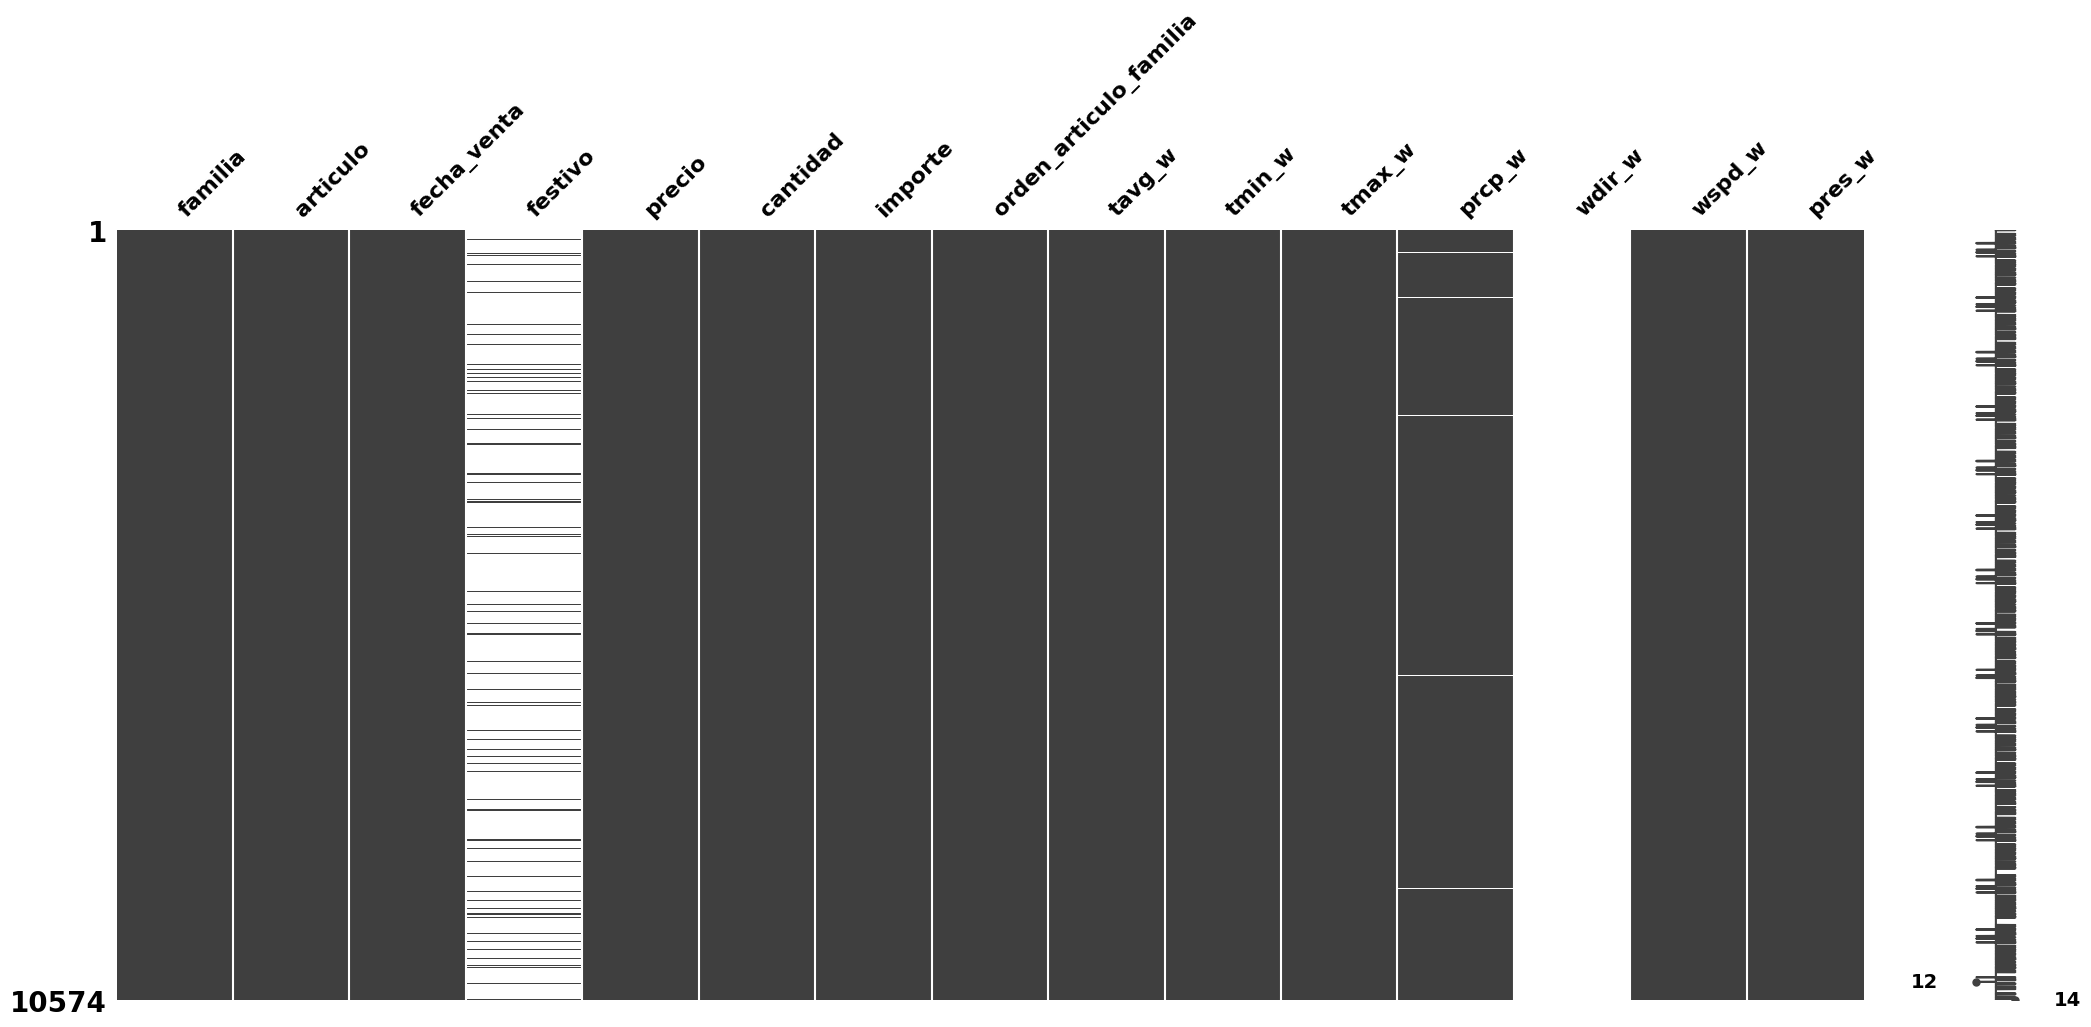

In [25]:
# 3_Gráfica visual de valores nulos, tengo que usar el método .to_pandas
msno.matrix(df.to_pandas())

In [26]:
# 4_Vamos a comprobar si hay duplicados
num_duplicated = df.is_duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicated}")

Número de filas duplicadas: 0


In [27]:
# 4_Encuentra duplicados por varias columnas en Polars (sin argumento 'subset', solo los nombres de columnas)
# Creo una columna temporal que concatene fecha_venta y articulo
# Me está dando bastante problemas Polars
df_ext = df.with_columns(
    (pl.col("fecha_venta").cast(pl.Utf8) + "_" + pl.col("articulo").cast(pl.Utf8)).alias("fecha_articulo")
)

# Busco duplicados de la columna
duplicated_mask = df_ext["fecha_articulo"].is_duplicated()
# Filtro para ver solo las filas duplicadas
df_double = df_ext.filter(duplicated_mask)

# Visualizo sin la columna temporal
print(df_double.drop("fecha_articulo"))


shape: (0, 15)
┌─────────┬──────────┬─────────────┬─────────┬───┬────────┬────────┬────────┬────────┐
│ familia ┆ articulo ┆ fecha_venta ┆ festivo ┆ … ┆ prcp_w ┆ wdir_w ┆ wspd_w ┆ pres_w │
│ ---     ┆ ---      ┆ ---         ┆ ---     ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ str     ┆ i64      ┆ date        ┆ str     ┆   ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞═════════╪══════════╪═════════════╪═════════╪═══╪════════╪════════╪════════╪════════╡
└─────────┴──────────┴─────────────┴─────────┴───┴────────┴────────┴────────┴────────┘


Al buscar filas duplicadas por las columnas "fecha_venta" y "articulo", el DataFrame resultante está vacío. Por tanto, podemos afirmar que no existen duplicados para esta combinación de claves.


In [28]:
# Voy a definir los tipos númericos, ya que polars no tiene el método "is_numeric_dtype"

# (Me estoy empezando a arrepentir de usar Polars)

# Num. types
numeric_types = [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]

# Pruebo la definición
numeric_cols = [col for col in df.columns if df[col].dtype in numeric_types]
df.select(numeric_cols).describe()

statistic,articulo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",10574.0,10574.0,10574.0,10574.0,10574.0,10574.0,10574.0,10574.0,10477.0,0.0,10574.0,10574.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,10574.0,0.0,0.0
"""mean""",3945.091734,15.414053,1514.567485,5087.728732,2.961982,19.39129,15.222035,24.909504,0.793118,null,14.323492,1018.015992
"""std""",2404.630373,17.003998,1629.810279,3015.705325,1.395454,5.349137,5.506365,5.931939,4.279853,null,5.313389,5.113184
"""min""",417.0,0.865,13.200001,99.0,1.0,7.3,1.1,13.3,0.0,null,6.1,1004.4
"""25%""",1043.0,2.591,165.0,3166.35003,2.0,14.6,10.9,19.7,0.0,null,10.9,1014.5
"""50%""",5403.0,3.545,924.0,4455.0,3.0,19.4,14.7,24.7,0.0,null,12.5,1017.2
"""75%""",6286.0,34.091,2409.0,6266.261089,4.0,23.8,19.9,29.6,0.0,null,16.8,1021.0
"""max""",6549.0,43.5,12210.0,35991.229584,5.0,33.5,27.5,42.6,46.8,null,46.5,1032.8


In [29]:
# Resumen de los datos, he necesitado pasarlo todo a String, si no daba error ya que Polars es bastante exigente con los tipos


summary_dict = {
    "Columna": [str(col) for col in df.columns],
    "Tipo": [str(df[col].dtype) for col in df.columns],
    "Cardinalidad": [str(df[col].n_unique()) for col in df.columns],
    "Granularidad (%)": [str(round(df[col].n_unique() / df.height * 100, 2)) for col in df.columns],
    "Nulos_Pct (%)": [str(round(df[col].null_count() /df.height * 100, 2)) for col in df.columns],
    "Max": [str(df[col].max()) if df[col].dtype in numeric_types else None for col in df.columns],
    "Min": [str(df[col].min()) if df[col].dtype in numeric_types else None for col in df.columns]
}

summary = pl.DataFrame(summary_dict)

summary

Columna,Tipo,Cardinalidad,Granularidad (%),Nulos_Pct (%),Max,Min
str,str,str,str,str,str,str
"""familia""","""String""","""3""","""0.03""","""0.0""",null,null
"""articulo""","""Int64""","""15""","""0.14""","""0.0""","""6549""","""417"""
"""fecha_venta""","""Date""","""748""","""7.07""","""0.0""",null,null
"""festivo""","""String""","""27""","""0.26""","""92.08""",null,null
"""precio""","""Float64""","""92""","""0.87""","""0.0""","""43.5""","""0.8650000095367432"""
…,…,…,…,…,…,…
"""tmax_w""","""Float64""","""221""","""2.09""","""0.0""","""42.6""","""13.3"""
"""prcp_w""","""Float64""","""60""","""0.57""","""0.92""","""46.8""","""0.0"""
"""wdir_w""","""Float64""","""1""","""0.01""","""100.0""","""None""","""None"""


**Grupo de preguntas 2** (x minutos):

5. ¿Cuál es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¿hay fechas faltantes? Crea un gráfico de evolución temporal para la variable "cantidad" que muestre el producto "6549".

6. Separando por producto, ¿hay outliers en la variable "cantidad"?

In [30]:
# 5_Recordar rango de fechas
print(df["fecha_venta"].min(), df["fecha_venta"].max())

print(f"Fecha mínima: {df['fecha_venta'].min()}")
print(f"Fecha máxima: {df['fecha_venta'].max()}")



2021-05-01 2023-05-18
Fecha mínima: 2021-05-01
Fecha máxima: 2023-05-18


In [31]:
# Comprobar si hay fechas faltantes por producto

all_dates = pl.date_range(
    start=df["fecha_venta"].min(),
    end=df["fecha_venta"].max(),
    interval="1d",
    eager=True
)

# Función para ver fechas faltantes para cada producto
id_product = 6549
product_date = df.filter(pl.col("articulo") == id_product)["fecha_venta"].unique()
missing_date = set(all_dates.to_list()) - set(product_date.to_list())

print(f"Fechas faltantes para el producto {id_product}:")
print(sorted(missing_date))
print(f"Total días sin datos: {len(missing_date)}")




Fechas faltantes para el producto 6549:
[datetime.date(2021, 5, 3), datetime.date(2021, 5, 4), datetime.date(2021, 5, 5), datetime.date(2021, 5, 6), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 18), datetime.date(2021, 5, 19), datetime.date(2021, 5, 20), datetime.date(2021, 5, 25), datetime.date(2021, 5, 26), datetime.date(2021, 6, 1), datetime.date(2021, 6, 2), datetime.date(2021, 6, 7), datetime.date(2021, 6, 8), datetime.date(2021, 6, 10), datetime.date(2021, 6, 15), datetime.date(2021, 6, 16), datetime.date(2021, 6, 17), datetime.date(2021, 7, 1), datetime.date(2021, 7, 8), datetime.date(2021, 7, 12), datetime.date(2021, 7, 13), datetime.date(2021, 7, 14), datetime.date(2021, 7, 19), datetime.date(2021, 7, 22), datetime.date(2021, 7, 28), datetime.date(2021, 7, 29), datetime.date(2021, 8, 2), datetime.date(2021, 8, 3), datetime.date(2021, 8, 4), datetime.date(2021, 8, 5), datetime.date(2021, 8, 17), datetime.date(2021, 8, 18), datetime.date(2021, 8

In [32]:
# Hecha la anterior celda, con la función para un producto, haré la función para todos los productos
full_dates = pl.date_range(
    start=df["fecha_venta"].min(),
    end=df["fecha_venta"].max(),
    interval="1d",
    eager=True
).to_list()

# Lista de productos únicos
products = df["articulo"].unique().to_list()

# Dict para guardar fechas faltantes
missing_dates = {}

for prod in products:
    prod_dates = df.filter(pl.col("articulo") == prod)["fecha_venta"].unique().to_list()
    missing = sorted(set(full_dates) - set(prod_dates))
    if missing:  # Solo debería guardar si faltan fechas
        missing_dates[prod] = missing

# Muestra resultado resumido
print(f"Productos con fechas faltantes: {len(missing_dates)} de {len(products)} productos\n")
for prod, missing in missing_dates.items():
    print(f"Producto {prod}: {len(missing)} fechas faltantes")




Productos con fechas faltantes: 8 de 15 productos

Producto 5403: 107 fechas faltantes
Producto 5404: 98 fechas faltantes
Producto 5803: 3 fechas faltantes
Producto 6286: 2 fechas faltantes
Producto 6425: 1 fechas faltantes
Producto 6451: 74 fechas faltantes
Producto 6523: 49 fechas faltantes
Producto 6549: 312 fechas faltantes


In [33]:
# Para ver fechas concretas para cada uno
example = list(missing_dates.keys())[0] if missing_dates else None
if example:
    print(f"\nFechas faltantes para el producto {example}:")
    print(missing_dates[example])


Fechas faltantes para el producto 5403:
[datetime.date(2021, 5, 13), datetime.date(2021, 5, 19), datetime.date(2021, 5, 25), datetime.date(2021, 5, 27), datetime.date(2021, 6, 2), datetime.date(2021, 6, 15), datetime.date(2021, 6, 17), datetime.date(2021, 6, 29), datetime.date(2021, 7, 7), datetime.date(2021, 7, 20), datetime.date(2021, 8, 3), datetime.date(2021, 8, 12), datetime.date(2021, 8, 13), datetime.date(2021, 10, 13), datetime.date(2021, 10, 25), datetime.date(2021, 10, 27), datetime.date(2021, 11, 8), datetime.date(2021, 11, 18), datetime.date(2021, 11, 23), datetime.date(2021, 11, 25), datetime.date(2021, 12, 2), datetime.date(2021, 12, 9), datetime.date(2021, 12, 12), datetime.date(2021, 12, 14), datetime.date(2021, 12, 15), datetime.date(2022, 1, 5), datetime.date(2022, 1, 6), datetime.date(2022, 1, 7), datetime.date(2022, 1, 18), datetime.date(2022, 1, 28), datetime.date(2022, 2, 2), datetime.date(2022, 2, 9), datetime.date(2022, 2, 14), datetime.date(2022, 2, 15), datet

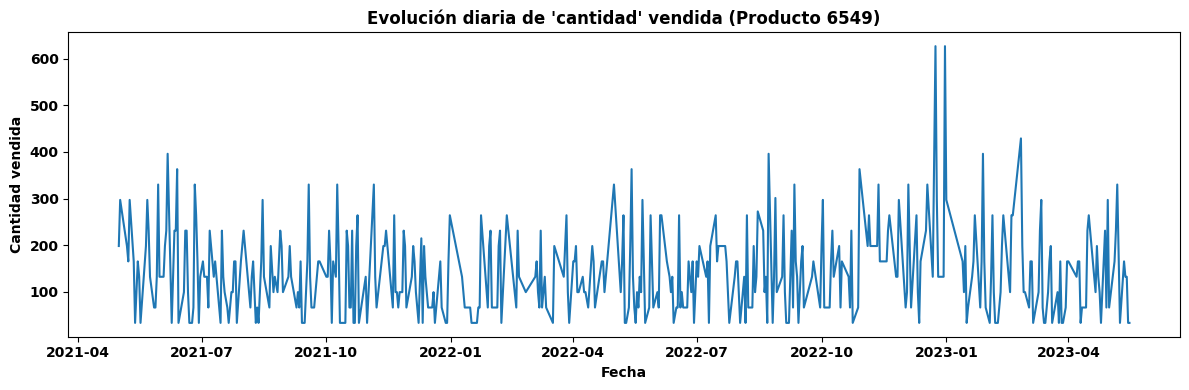

In [34]:
PLOTS_EDA_DIR = r"d:\PersonalProjects\Panadería Datathon\outputs\plots"

# Gráfico de evolución temporal para el producto 6549

# Filtro datos del producto y los ordeno por fecha
df_6549 = df.filter(pl.col("articulo") == 6549).sort("fecha_venta")

# Ploteo
plt.figure(figsize=(12, 4))
plt.plot(df_6549["fecha_venta"].to_pandas(), df_6549["cantidad"].to_pandas())
plt.title("Evolución diaria de 'cantidad' vendida (Producto 6549)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "daily_evolution_sold_6549"))
plt.show()

In [35]:
# 6_Outliers, calculo Q1, Q3, IQR
q1 = df_6549["cantidad"].quantile(0.25)
q3 = df_6549["cantidad"].quantile(0.75)
iqr = q3 - q1
lim_sup = q3 + 1.5 * iqr
lim_inf = q1 - 1.5 * iqr

# Filtrar outliers
outliers_6549 = df_6549.filter(
    (pl.col("cantidad") < lim_inf) | (pl.col("cantidad") > lim_sup)
)

print(f"Número de outliers para el producto 6549: {outliers_6549.shape[0]}")
outliers_6549

Número de outliers para el producto 6549: 3


familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,i64,date,str,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""PASTELERIA""",6549,2022-12-24,"""Nochebuena""",32.591,627.0,20434.557549,5,13.7,10.1,19.8,0.0,null,10.5,1023.3
"""PASTELERIA""",6549,2022-12-31,"""Nochevieja""",32.591,627.0,20434.556961,5,11.4,5.2,20.5,0.0,null,12.4,1027.2
"""PASTELERIA""",6549,2023-02-25,null,32.591,429.0,13981.539291,5,10.6,6.8,16.3,0.0,null,11.5,1009.2


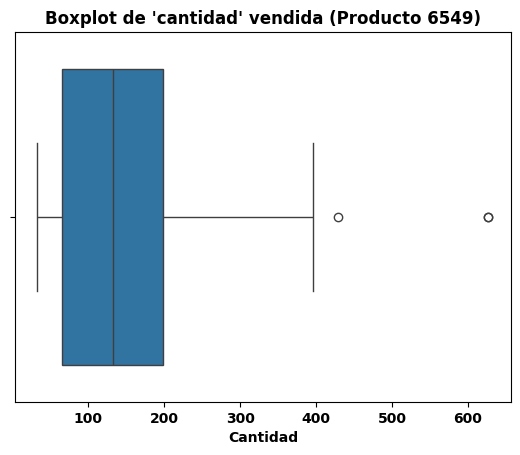

In [36]:
# Boxplot para ver outliers, hay que pasarlo a pandas también
import seaborn as sns

sns.boxplot(x=df_6549["cantidad"].to_pandas())
plt.title("Boxplot de 'cantidad' vendida (Producto 6549)")
plt.xlabel("Cantidad")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "boxplot_6549"), dpi=300)
plt.show()




In [37]:
# Mostramos valores de esos outliers
print(outliers_6549[["fecha_venta", "cantidad"]])

shape: (3, 2)
┌─────────────┬──────────┐
│ fecha_venta ┆ cantidad │
│ ---         ┆ ---      │
│ date        ┆ f64      │
╞═════════════╪══════════╡
│ 2022-12-24  ┆ 627.0    │
│ 2022-12-31  ┆ 627.0    │
│ 2023-02-25  ┆ 429.0    │
└─────────────┴──────────┘


In [38]:
# Vamos a intentar hacer una función que detecte todos los outliers del dataset

def get_outliers_product(df, columna_producto="articulo", columna_valor="cantidad"):
    outliers_list = []
    products = df[columna_producto].unique().to_list()

    for prod in products:
        subdf = df.filter(pl.col(columna_producto) == prod)
        if subdf.shape[0] < 5:
            continue   # Ignora productos con pocos datos

        q1 = subdf[columna_valor].quantile(0.25)
        q3 = subdf[columna_valor].quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 - 1.5 * iqr

        outliers = subdf.filter((pl.col(columna_valor) < lim_inf) | (pl.col(columna_valor) > lim_sup))
        if outliers.shape[0] > 0:
            outliers_list.append(outliers)

    if outliers_list:
        return pl.concat(outliers_list)
    else:
        return pl.DataFrame([])
    
# Probamos la función
all_outliers = get_outliers_product(df)
print(f"Número total de outliers en todo el dataset: {all_outliers.shape[0]}")
all_outliers.head()

Número total de outliers en todo el dataset: 9853


familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
str,i64,date,str,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""PANADERIA""",417,2021-05-01,null,4.038,792.0,3198.096043,5,17.2,11.9,22.8,0.0,null,14.2,1014.0
"""PANADERIA""",417,2021-05-02,"""Día de la Madre""",4.038,891.0,3597.857948,5,16.3,10.8,23.2,0.0,null,15.7,1015.9
"""PANADERIA""",417,2021-05-03,"""Día de la Cruz""",4.038,990.0,3997.61998,5,15.3,12.7,20.1,6.5,null,9.7,1017.7
"""PANADERIA""",417,2021-05-04,null,4.038,924.0,3731.112015,5,16.5,12.0,20.9,0.0,null,12.1,1018.0
"""PANADERIA""",417,2021-05-05,null,4.038,924.0,3731.112036,5,16.7,12.3,21.7,0.0,null,13.8,1016.5


In [39]:
# Porcentaje total de outliers en el dataset 
print(f"Porcentaje de outliers: {100 * all_outliers.shape[0] / df.shape[0]:.2f}%")


Porcentaje de outliers: 93.18%


### Sobre los outliers detectados en "cantidad"

Al aplicar el método clásico de outliers (usando el rango intercuartílico o IQR), hemos visto que más del **90% de las observaciones** son marcadas como outliers. Esto no significa necesariamente que haya errores en los datos, sino que la distribución de "cantidad" es **muy desigual**. En ventas reales es habitual encontrar:

- Muchos días con ventas cero (lo que estrecha el IQR).
- Días puntuales con pedidos altos por promociones, eventos o simplemente variabilidad normal.
- Grandes diferencias entre productos (algunos con ventas constantes y otros casi nunca).

Por eso, el método IQR clásico se vuelve **demasiado sensible** en este contexto y marca como outlier la mayoría de las ventas.  
En estos casos, conviene revisar los datos visualmente y, si es necesario, ajustar el método (por ejemplo, usando un umbral más amplio, percentiles, o solo revisando los casos extremos).

La mayoría de estos "outliers" probablemente sean ventas válidas y reflejan la realidad de los datos, no errores.**


In [40]:
# Tablas o dataframes generados, directorio
TABLES_DIR = r"d:\PersonalProjects\Panadería Datathon\outputs\tables"

# Función para contar outliers por producto (usando 1.5 x IQR)
def count_outliers_per_product(df, columna_producto="articulo", columna_valor="cantidad"):
    summary = []
    products = df[columna_producto].unique().to_list()
    for prod in products:
        subdf = df.filter(pl.col(columna_producto) == prod)
        if subdf.shape[0] < 5:
            continue
        q1 = subdf[columna_valor].quantile(0.25)
        q3 = subdf[columna_valor].quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr
        n_outliers = subdf.filter((pl.col(columna_valor) < lim_inf) | (pl.col(columna_valor) > lim_sup)).shape[0]
        summary.append({"articulo": prod, "outliers_cantidad": n_outliers, "n_total": subdf.shape[0]})
    return pl.DataFrame(summary)

# Ejecuto y muestro la tabla
table_outliers = count_outliers_per_product(df)
table_outliers = table_outliers.with_columns(
    (pl.col("outliers_cantidad") / pl.col("n_total") * 100).alias("porcentaje_outliers")
)
table_outliers = table_outliers.sort("porcentaje_outliers", descending=True)

table_outliers.write_csv(os.path.join(TABLES_DIR, "outliers_productos.csv"))
print(table_outliers)


shape: (15, 4)
┌──────────┬───────────────────┬─────────┬─────────────────────┐
│ articulo ┆ outliers_cantidad ┆ n_total ┆ porcentaje_outliers │
│ ---      ┆ ---               ┆ ---     ┆ ---                 │
│ i64      ┆ i64               ┆ i64     ┆ f64                 │
╞══════════╪═══════════════════╪═════════╪═════════════════════╡
│ 6286     ┆ 59                ┆ 746     ┆ 7.908847            │
│ 5803     ┆ 53                ┆ 745     ┆ 7.114094            │
│ 5403     ┆ 37                ┆ 641     ┆ 5.772231            │
│ 6523     ┆ 36                ┆ 699     ┆ 5.150215            │
│ 3880     ┆ 38                ┆ 748     ┆ 5.080214            │
│ …        ┆ …                 ┆ …       ┆ …                   │
│ 6425     ┆ 25                ┆ 747     ┆ 3.34672             │
│ 417      ┆ 19                ┆ 748     ┆ 2.540107            │
│ 3960     ┆ 15                ┆ 748     ┆ 2.005348            │
│ 6549     ┆ 3                 ┆ 436     ┆ 0.688073            │
│ 1084    

In [41]:
# Miro los 5 productos con mayor porcentaje de outliers
top_5_outliers = table_outliers.head(5)

print("Top 5 productos con mayor % de outliers en 'cantidad':")
print(top_5_outliers)


Top 5 productos con mayor % de outliers en 'cantidad':
shape: (5, 4)
┌──────────┬───────────────────┬─────────┬─────────────────────┐
│ articulo ┆ outliers_cantidad ┆ n_total ┆ porcentaje_outliers │
│ ---      ┆ ---               ┆ ---     ┆ ---                 │
│ i64      ┆ i64               ┆ i64     ┆ f64                 │
╞══════════╪═══════════════════╪═════════╪═════════════════════╡
│ 6286     ┆ 59                ┆ 746     ┆ 7.908847            │
│ 5803     ┆ 53                ┆ 745     ┆ 7.114094            │
│ 5403     ┆ 37                ┆ 641     ┆ 5.772231            │
│ 6523     ┆ 36                ┆ 699     ┆ 5.150215            │
│ 3880     ┆ 38                ┆ 748     ┆ 5.080214            │
└──────────┴───────────────────┴─────────┴─────────────────────┘


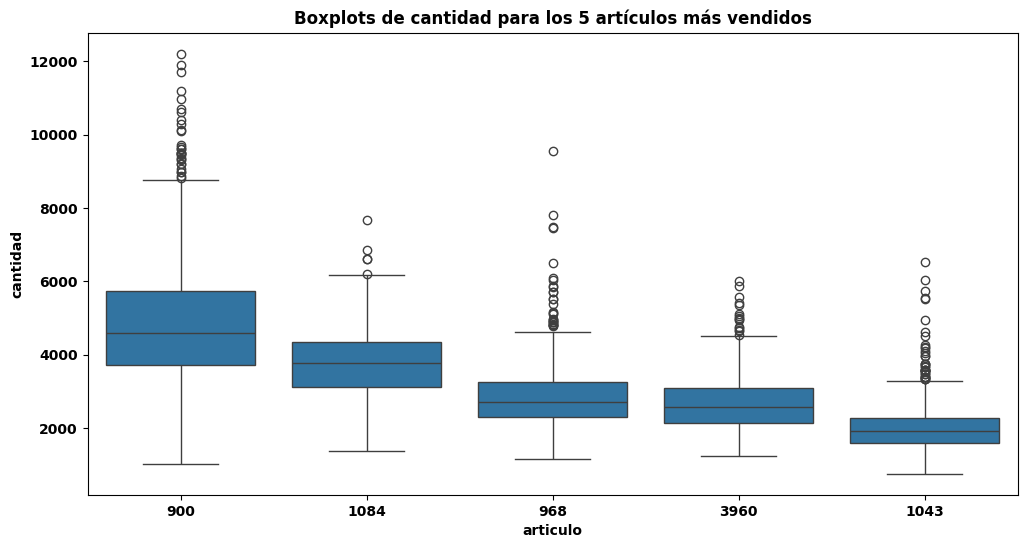

In [42]:
# Vamos a visualizar más Boxplots para los productos top
top_items = df.group_by("articulo").agg(pl.col("cantidad").sum()).sort("cantidad", descending=True)["articulo"].to_list()[:5]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=pd.concat([df.filter(pl.col("articulo") == art).select(["cantidad"]).to_pandas().assign(articulo=str(art)) for art in top_items]),
    x="articulo",
    y="cantidad"
)
plt.title("Boxplots de cantidad para los 5 artículos más vendidos")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "outliers", "boxplots_outliers_top5_products"), dpi=300)
plt.show()

### Boxplot de cantidades para los 5 artículos más vendidos
El gráfico muestra la dispersión diaria de ventas para los cinco productos más vendidos.
Se aprecian diferencias de escala y numerosos outliers, lo que indica días con ventas anómalamente altas.
Este análisis ayuda a identificar variabilidad y detectar posibles anomalías en los datos de ventas.

#### 4.2. Análisis de la variable a predecir

Este apartado tiene como cometido comprender la evolución de la variable "cantidad" en el tiempo y como se relaciona esta consigo misma.

**Grupo de preguntas 3** (x minutos):

7. Crea un gráfico de la evolución temporal general de la variable "cantidad". Nota: Se debe de agrupar.

8. Crea un gráfico de la evolución temporal por familia de la variable "cantidad". Nota: Se debe de agrupar.

9. Crea un gráfico de la evolución temporal por artículo de la variable "cantidad". Nota: Se debe de agrupar.

10. Se que hay mucho ruido, pero ¿a simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

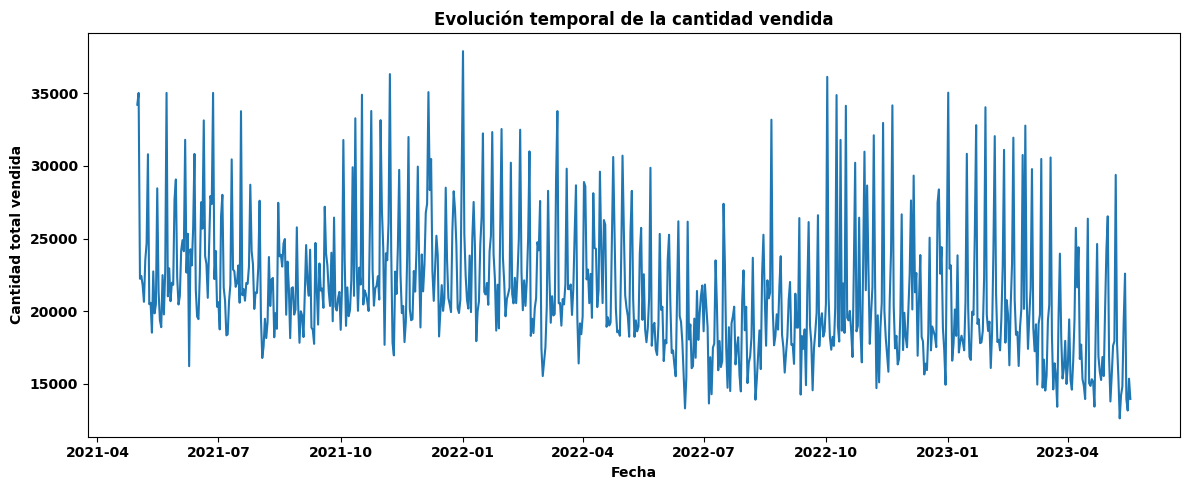

In [83]:
# 7_Evolución temporal general de la variable "cantidad"

# Voy a agrupar por fecha y sumo la cantidad total vendida cada día
quantity_evo = (
    df.group_by("fecha_venta")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("fecha_venta")
)

# Paso a pandas para el plotting
plt.figure(figsize=(12, 5))
plt.plot(quantity_evo["fecha_venta"].to_pandas(), quantity_evo["cantidad_total"].to_pandas())
plt.title("Evolución temporal de la cantidad vendida")
plt.xlabel("Fecha")
plt.ylabel("Cantidad total vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "total_quantity_sales"), dpi=300)
plt.show()

#### Evolución temporal de la cantidad vendida

El gráfico muestra la evolución diaria de la cantidad total vendida en la panadería durante el periodo analizado.  
Se aprecia bastante ruido en las ventas diarias y no se observa una tendencia clara a simple vista, aunque podría haber patrones estacionales o picos puntuales.  
Este comportamiento es habitual en negocios minoristas, donde factores como la demanda variable o eventos especiales afectan la serie temporal.


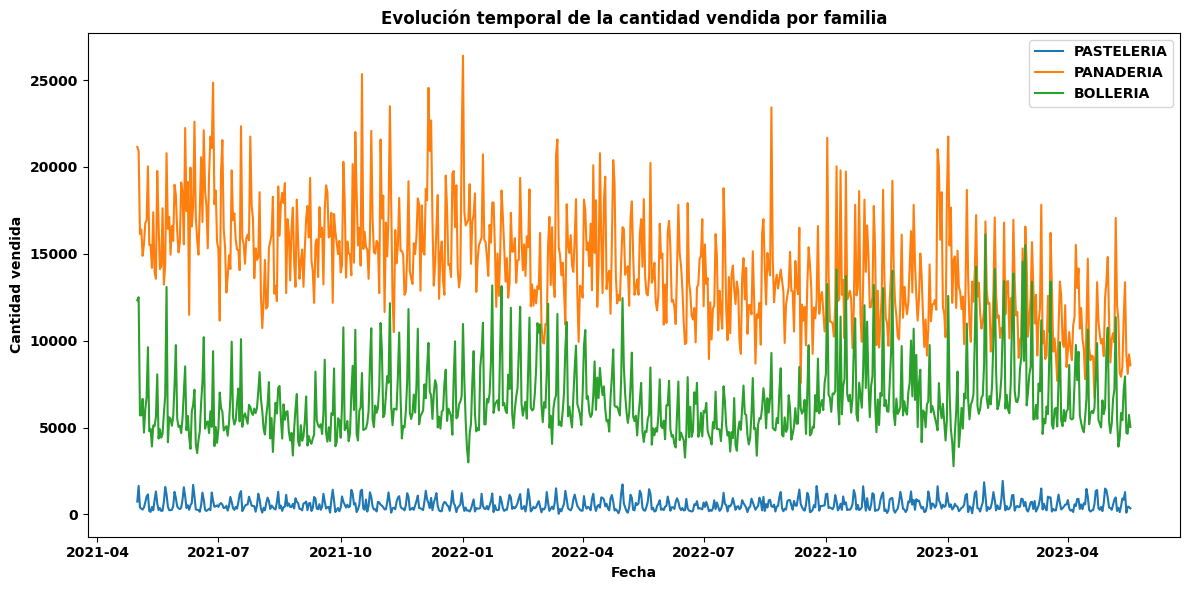

In [44]:
# 8_Evolución temporal por familia de la variable "cantidad"

# Agrupar por fecha y familia
agg_familia = (
    df.group_by(["fecha_venta", "familia"])
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort(["familia", "fecha_venta"])
)

familias = agg_familia["familia"].unique().to_list()

plt.figure(figsize=(12, 6))
for fam in familias:
    data = agg_familia.filter(pl.col("familia") == fam)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), label=fam)
plt.title("Evolución temporal de la cantidad vendida por familia")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_familia", "total_sales_per_family"), dpi=300)
plt.show()   

#### Evolución temporal de la cantidad vendida por familia

La gráfica muestra cómo evoluciona la cantidad total vendida a lo largo del tiempo para cada familia de productos.  
Se observan diferencias claras en el volumen y el comportamiento de ventas según la familia, con algunas presentando más variabilidad o picos en fechas concretas.  
Este análisis ayuda a identificar patrones específicos y posibles oportunidades de mejora para cada línea de producto.

Destaca especialmente la familia PANADERÍA, que muestra un volumen de ventas mucho mayor y una mayor estabilidad/picos a lo largo del tiempo, en comparación con el resto de familias. Este comportamiento puede deberse a la popularidad del producto, promociones específicas, una mayor demanda en ciertos periodos, o simplemente que son productos disponibles cada día, a excepción de otros de las demás familias.


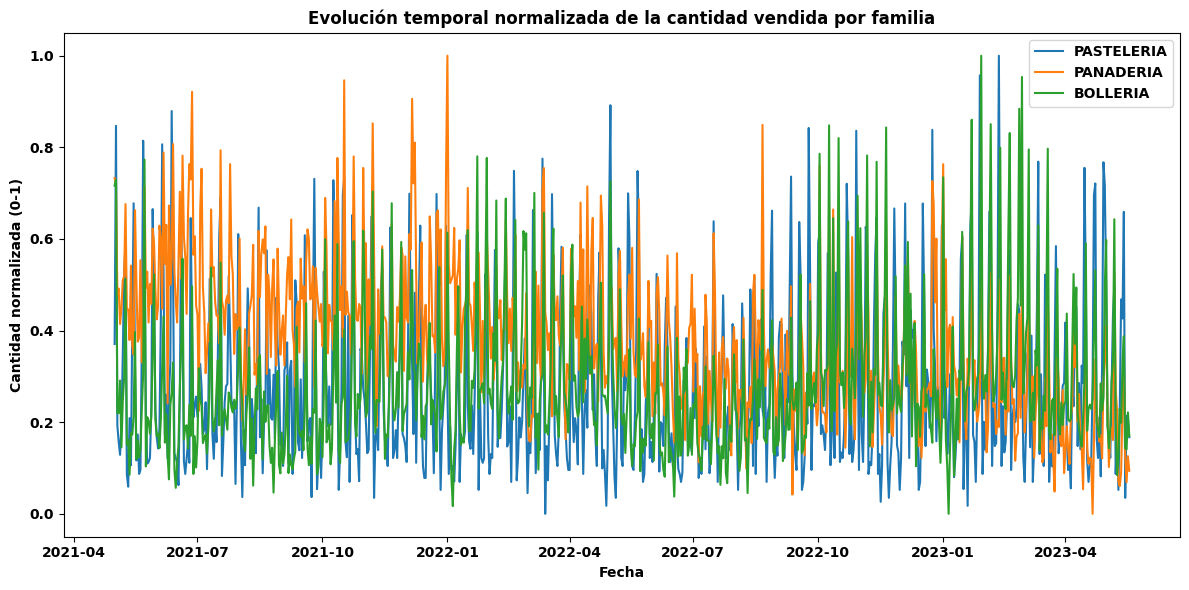

In [45]:
# Normalizamos la variable "cantidad", para una fácil comparación aunque tengan escalas muy diferents las familias
from sklearn.preprocessing import MinMaxScaler

# Primero agrupamos por familia y fecha (como antes)
agg_familia = (
    df.group_by(["fecha_venta", "familia"])
      .agg(pl.col("cantidad").sum().alias("cantidad_total"))
      .sort(["familia", "fecha_venta"])
)

# Normaliza la cantidad para cada familia (0-1)
result = []
for fam in agg_familia["familia"].unique().to_list():
    sub = agg_familia.filter(pl.col("familia") == fam)
    scaler = MinMaxScaler()
    cantidades_norm = scaler.fit_transform(sub["cantidad_total"].to_numpy().reshape(-1,1)).flatten()
    temp_df = sub.with_columns([
        pl.Series("cantidad_norm", cantidades_norm)
    ])
    result.append(temp_df)

agg_norm = pl.concat(result)

# Plot
plt.figure(figsize=(12,6))
for fam in agg_norm["familia"].unique().to_list():
    datos = agg_norm.filter(pl.col("familia") == fam)
    plt.plot(datos["fecha_venta"].to_pandas(), datos["cantidad_norm"].to_pandas(), label=fam)
plt.title("Evolución temporal normalizada de la cantidad vendida por familia")
plt.xlabel("Fecha")
plt.ylabel("Cantidad normalizada (0-1)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR,"eda_familia", "total_sales_scaler_per_family"), dpi=300)
plt.show()


#### Evolución temporal normalizada de la cantidad vendida por familia

En este gráfico, la cantidad vendida por cada familia de productos se ha normalizado entre 0 y 1, para facilitar la comparación de patrones y tendencias independientemente del volumen de ventas. 

La normalización permite observar similitudes o diferencias en la evolución relativa de cada familia a lo largo del tiempo, destacando posibles efectos estacionales o comportamientos sincronizados entre productos.

> **Interpretación de la evolución temporal normalizada por familia:**  
> 
> Las tres familias (PASTELERIA, BOLLERIA y PANADERIA) presentan una evolución diaria con mucha variabilidad y sin una tendencia clara a largo plazo.  
> No se observan picos sincronizados fuertes ni patrones de estacionalidad evidentes entre las familias: sus máximos y mínimos aparecen en fechas distintas.  
> La demanda parece estar influida más por factores específicos de cada producto que por patrones generales o estacionales.  
> En resumen, cada familia evoluciona de forma relativamente independiente y con bastante ruido día a día.



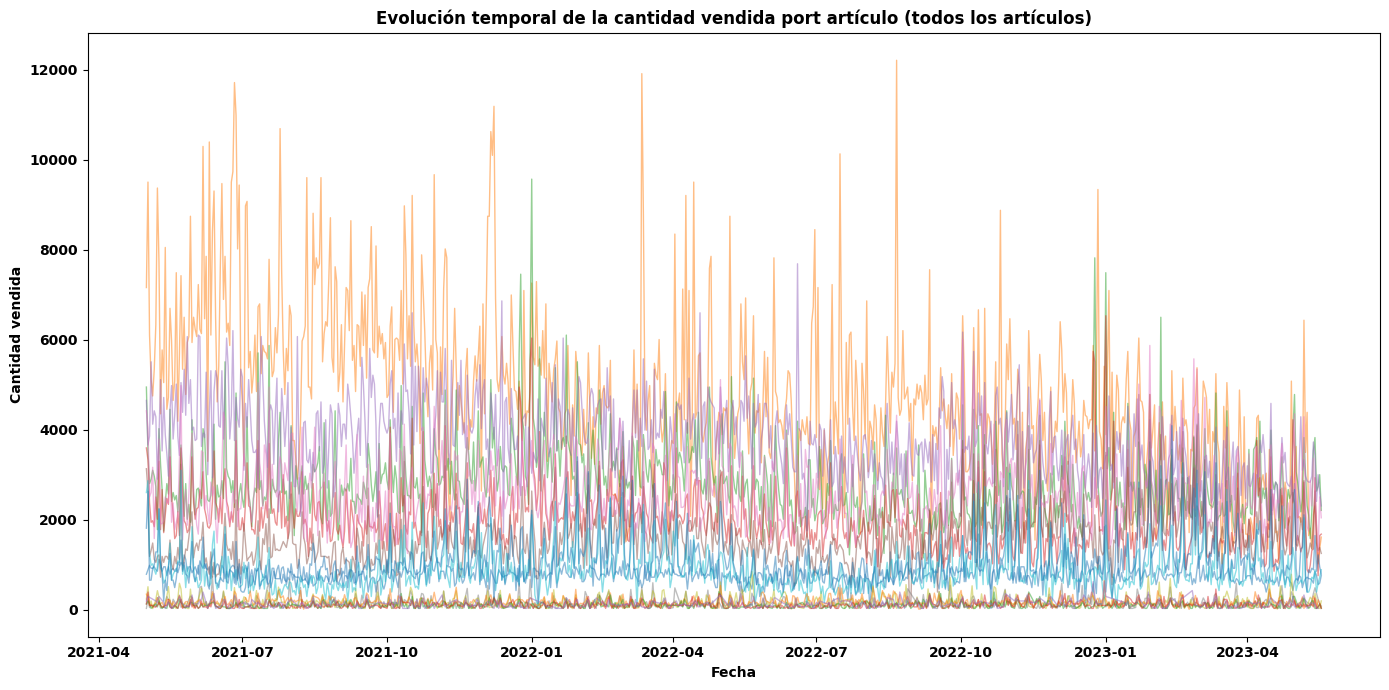

In [46]:
# 9_Evolución temporal por artículo de la variable "cantidad"

# Agrupar por fecha y artículo
agg_articulos = (
    df.group_by(["fecha_venta", "articulo"])
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort(["articulo", "fecha_venta"])
)

# Artículos únicos
all_items = agg_articulos["articulo"].unique().to_list()

# Plotting
plt.figure(figsize=(14, 7))
for item in all_items:
    data = agg_articulos.filter(pl.col("articulo") == item)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), alpha=0.5, linewidth=1)
plt.title("Evolución temporal de la cantidad vendida port artículo (todos los artículos)") 
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "total_sales_per_item"), dpi=300)
plt.show()



### Evolución temporal de la cantidad vendida por artículo

En este gráfico se representa la evolución diaria de la cantidad vendida para **cada artículo** del catálogo. Cada línea corresponde a un artículo distinto.

Como era de esperar, el gráfico muestra un alto nivel de ruido visual debido al gran número de artículos representados, lo que hace que resulte difícil identificar patrones concretos para productos individuales. Sin embargo, esta visualización global es útil para hacerse una idea general del comportamiento conjunto, detectar picos generales de demanda o posibles anomalías a nivel agregado.

> **Nota:** Por motivos de claridad, no se ha incluido una leyenda para cada artículo, ya que haría el gráfico ilegible. Para un análisis más detallado, es recomendable seleccionar artículos concretos y analizar sus series de forma individual.


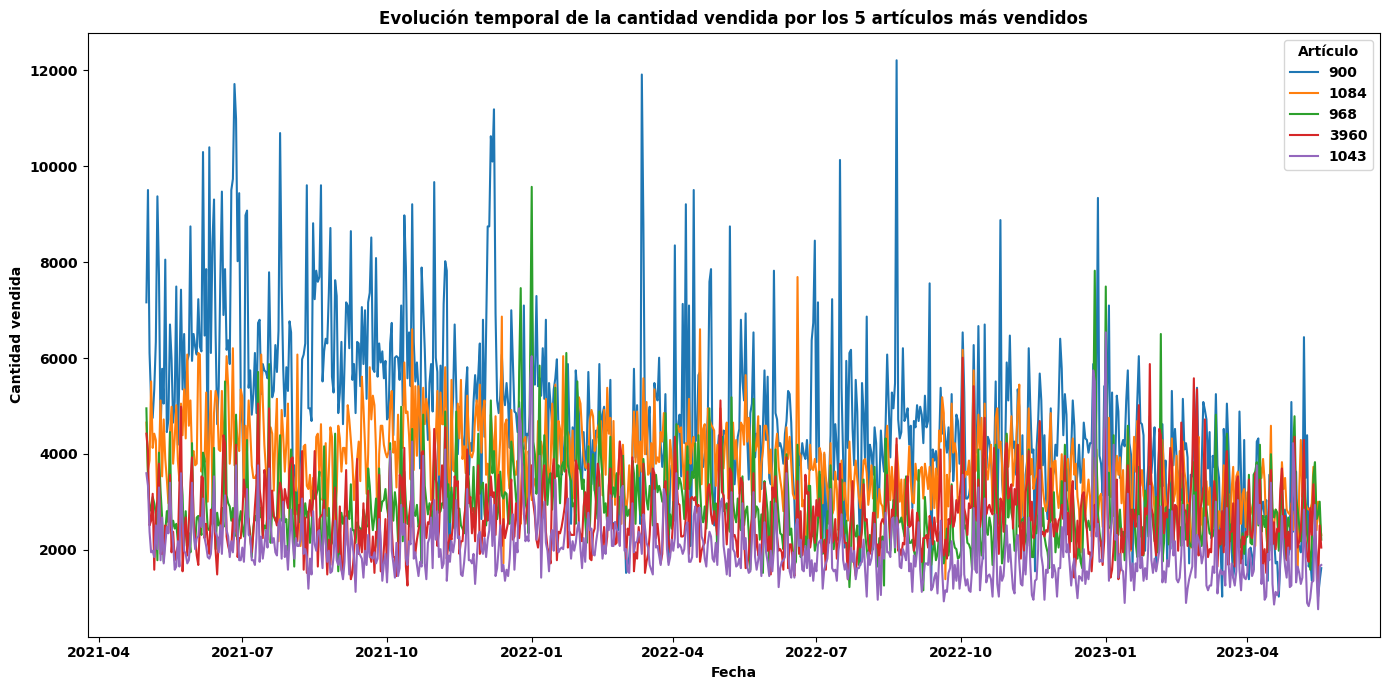

In [47]:
# Me voy a centrar en los artículos más vendidos para recibir un ploteo más limpio

# Top 5 artículos más vendidos
best_five_items = (
    df.group_by("articulo")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("cantidad_total", descending=True)
    .head(5)["articulo"]
    .to_list()
)

# Filtro con artículos top
df_top = df.filter(pl.col("articulo").is_in(best_five_items))

# Ploteo
plt.figure(figsize=(14, 7))
for item in best_five_items:
    data = agg_articulos.filter(pl.col("articulo") == item)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), label=str(item))
plt.title("Evolución temporal de la cantidad vendida por los 5 artículos más vendidos")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.legend(title="Artículo")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "total_sales_top5_items"), dpi=300)
plt.show()



### Evolución temporal de la cantidad vendida para los 5 artículos más vendidos

Este gráfico muestra la evolución diaria de la cantidad vendida para los cinco artículos más vendidos de la panadería.

Cada línea representa un artículo diferente, lo que permite comparar visualmente su comportamiento a lo largo del tiempo.  
Se observan **altos niveles de variabilidad** y picos pronunciados, lo que puede estar relacionado con la demanda estacional, promociones o eventos puntuales.

Este enfoque facilita detectar tendencias y posibles patrones para los productos más relevantes, a diferencia del gráfico global donde el exceso de líneas dificulta el análisis detallado.


### 10. ¿A simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

A simple vista, las series temporales analizadas muestran **mucho ruido** y una alta variabilidad diaria.  
No se aprecia una tendencia clara de aumento o descenso sostenido en la cantidad vendida para la mayoría de productos o familias.

Sin embargo, **sí parece haber cierta estacionalidad**: se observan repuntes y caídas recurrentes en varios periodos, especialmente en los productos más vendidos.  
Estas fluctuaciones podrían estar asociadas a fines de semana, festivos, campañas especiales o épocas del año concretas.

Para confirmar la presencia de tendencia o estacionalidad, sería recomendable aplicar técnicas estadísticas como la descomposición de series temporales o el análisis de autocorrelación.


**Grupo de preguntas 4** (x minutos):

11. Aplica alguna técnica estadística para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". Pista: Tomar la primera diferencia y, después, hacer un analisis de autocorrelación.

12. Sin aplicar la primera diferencia y creando nuevas columnas de fecha a partir de la variable "fecha_venta" (semana del año, mes del año, día de la semana, día del mes, día del año) comprueba realizando diferentes agrupaciones y gráficos si nuestro análisis de autocorrelación de nuestra variable cantidad nos mostraba lo correcto. Si encuentras algún gráfico que te llame la atención, baja el nivel del análisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por artículo).

In [48]:
# 11_Test de estacionalidad (en Polars)
from statsmodels.tsa.stattools import adfuller

def check_stationarity_polars(df, date_col="fecha_venta", value_col="cantidad"):
    """
    Agrupar por día, sumar la columna value_col, y aplicar el test de Dickey-Fuller aumentado (ADF)
    """
    # Agrupar y sumar por fecha en Polars
    grouped = (
        df.group_by(date_col)
        .agg(pl.col(value_col).sum().alias("cantidad_total"))
        .sort(date_col)
    )
    # Pasar a una series de Panda para el test
    cantidad_pandas = grouped["cantidad_total"].to_pandas()

    # ADF
    result = adfuller(cantidad_pandas)
    print("ADF Statistic: ", result[0])
    print("p-value: ", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    if (result[1] <= 0.05) & (result[4]["5%"] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

# Probamos la función
check_stationarity_polars(df, date_col="fecha_venta", value_col="cantidad")

ADF Statistic:  -1.4110271943456114
p-value:  0.5769782744361356
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
 Non-stationary 


<Figure size 800x500 with 0 Axes>

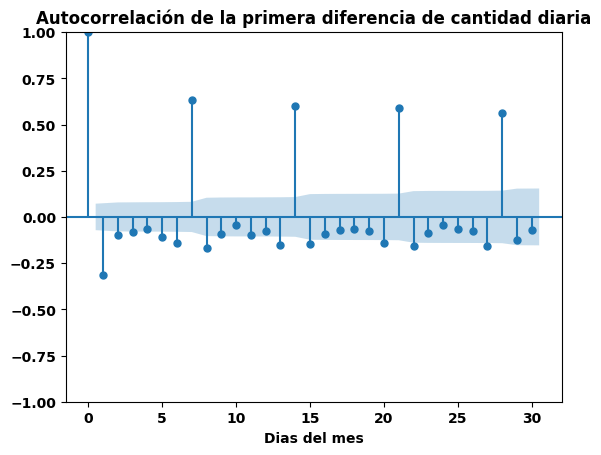

In [78]:
from statsmodels.graphics.tsaplots import plot_acf

# Agrupo la serie temporal general (cantidad total por día)
daily_serie = (
    df.group_by("fecha_venta")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("fecha_venta")
)

# Tomar la primera diferencia (numpy porqué tiene compatibilidad con statsmodels)
difference = daily_serie["cantidad_total"].to_numpy().astype(float)
first_dif = difference[1:] - difference[:-1]

# Análisis de autocorrelación
plt.figure(figsize=(8, 5))
plot_acf(first_dif, lags=30)
plt.title("Autocorrelación de la primera diferencia de cantidad diaria")
plt.xlabel("Dias del mes")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "autocorrelacion_primera_diferencia"), dpi=300)
plt.show()

#### ¿Hay estacionalidad en la evolución temporal de la cantidad?

El gráfico de autocorrelación de la primera diferencia de la cantidad diaria muestra **picos regulares y muy significativos en los rezagos 7, 14, 21, 28...**  
Esto indica claramente la presencia de **estacionalidad semanal**: las ventas siguen un patrón recurrente cada 7 días, que probablemente corresponde al ciclo de la semana (efecto fin de semana, días laborales, etc.).

> El análisis de autocorrelación es una técnica estándar para detectar patrones repetitivos en series temporales, y en este caso confirma la estacionalidad sugerida por la visualización.

**Conclusión:**  
La serie temporal de cantidad diaria presenta una clara **estacionalidad semanal** (evidenciada por el gráfico de autocorrelación) y, según el test de Dickey-Fuller, **no es estacionaria** (p-valor alto).  
Por tanto, hay patrones repetitivos y cambios en la media o la varianza a lo largo del tiempo.



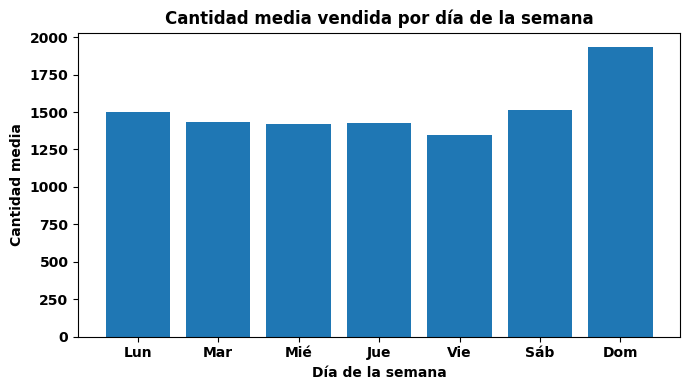

In [79]:
# 12_Añadir columnas temporales al DataFrame
df = df.with_columns([
    pl.col("fecha_venta").dt.week().alias("semana_ano"),
    pl.col("fecha_venta").dt.month().alias("mes_ano"),
    pl.col("fecha_venta").dt.weekday().alias("dia_semana"),
    pl.col("fecha_venta").dt.day().alias("dia_mes"),
    pl.col("fecha_venta").dt.ordinal_day().alias("dia_ano"),
])

#  Agrupación general por día de la semana
days = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
agg_week = (
    df.group_by("dia_semana")
      .agg(pl.col("cantidad").mean().alias("cantidad_media"))
      .sort("dia_semana")
)

plt.figure(figsize=(7,4))
plt.bar([days[d-1] for d in agg_week["dia_semana"]], agg_week["cantidad_media"])
# En el plt.bar resto 1 día porqué he visto con un "print" que mis días van del 1 al 7, y deberían ir del 0 al 6 y me daba error
plt.title("Cantidad media vendida por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Cantidad media")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quantity_mean_weekday"), dpi=300)
plt.show()


Esto confirma la estacionalidad semanal que insinuaba el gráfico de autocorrelación:

- Hay un patrón claro de ventas más altas en domingo.
- El resto de días están bastante equilibrados, pero el viernes es el más bajo.
- Esta información es muy útil para planificación y previsión de stock.

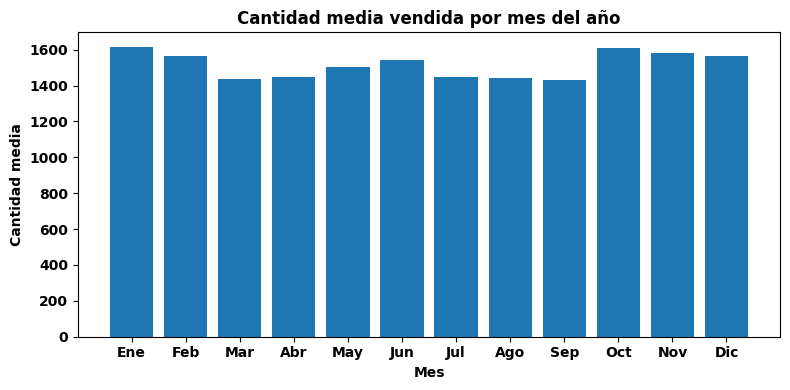

In [80]:
# Vamos a ver la cantidad media vendida por mes del año

# Agrupar y calcular media
agg_month = (
    df.group_by("mes_ano")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort("mes_ano")
)

# Meses
months = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

# Plotting
plt.figure(figsize=(8,4))
plt.bar([months[m-1] for m in agg_month["mes_ano"]], agg_month["cantidad_media"])
plt.title("Cantidad media vendida por mes del año")
plt.xlabel("Mes")
plt.ylabel("Cantidad media")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quantity_mean_month"), dpi=300)
plt.show()

No hay grandes diferencias extremas entre meses, pero se observa que enero, febrero, octubre y diciembre suelen tener valores más altos de venta media.

Julio, agosto y septiembre son los meses con menos ventas, lo cual tiene sentido por posible efecto vacaciones o reducción de actividad estacional.

Hay cierta estacionalidad anual (más ventas en invierno y final de año, menos en verano).

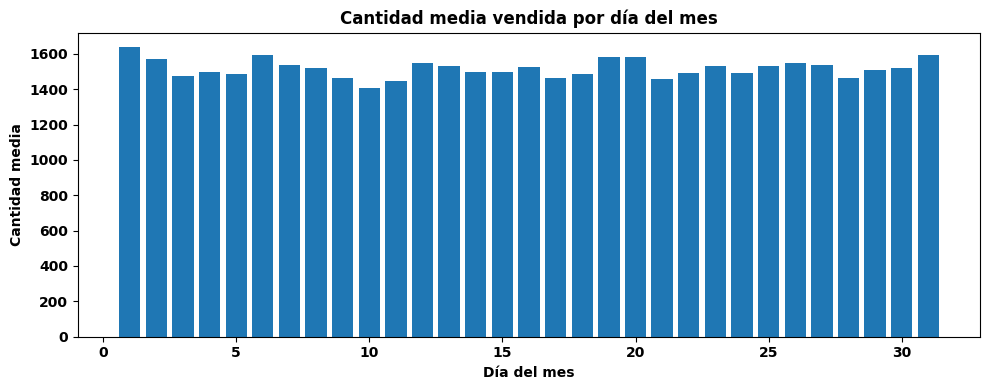

In [81]:
# Ahora la cantidad media por día del mes (1-30/31)

# Agrupar y calcular media
agg_monthday = (
    df.group_by("dia_mes")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort("dia_mes")
)

# Plot
plt.figure(figsize=(10, 4))
plt.bar(agg_monthday["dia_mes"].to_list(), agg_monthday["cantidad_media"])
plt.title("Cantidad media vendida por día del mes")
plt.xlabel("Día del mes")
plt.ylabel("Cantidad media")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quantity_mean_monthday"), dpi=300)
plt.show()

No se observan picos ni valles demasiado extremos; la cantidad media es bastante constante a lo largo del mes.

Se intuyen ligeros aumentos al principio y al final de mes, pero las diferencias no son muy pronunciadas.

Conclusión: No parece haber un patrón fuerte de ventas asociado al día del mes, más allá de pequeñas variaciones aleatorias.

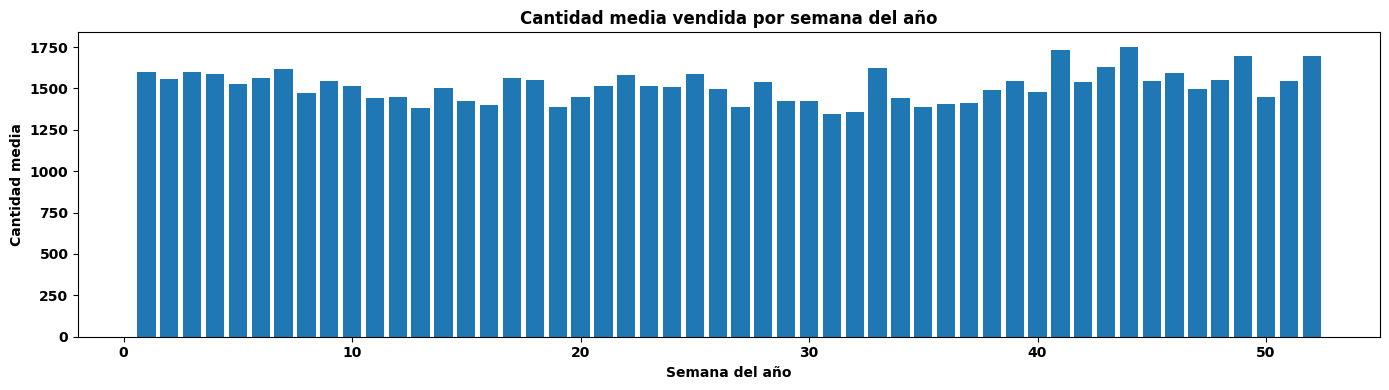

In [82]:
# Cantidad media vendida por semana del año

# Agrupar y calcular media
agg_week_year = (
    df.group_by("semana_ano")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort("semana_ano")
)

# Plotting
plt.figure(figsize=(14, 4))
plt.bar(agg_week_year["semana_ano"].to_list(), agg_week_year["cantidad_media"])
plt.title("Cantidad media vendida por semana del año")
plt.xlabel("Semana del año")
plt.ylabel("Cantidad media")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quantity_mean_weekyear"), dpi=300)
plt.show()

Se observa un comportamiento bastante estable durante la mayor parte del año.

Sin embargo, hay picos al final del año (alrededor de las semanas 40-52), lo que podría coincidir con temporadas festivas (Navidad, etc.).

También hay pequeñas subidas a lo largo del año, pero no hay una estacionalidad clarísima ni caídas bruscas.

Conclusión: La venta media semanal es bastante homogénea, pero se intuye un aumento en la recta final del año, probablemente por motivos estacionales o campañas.

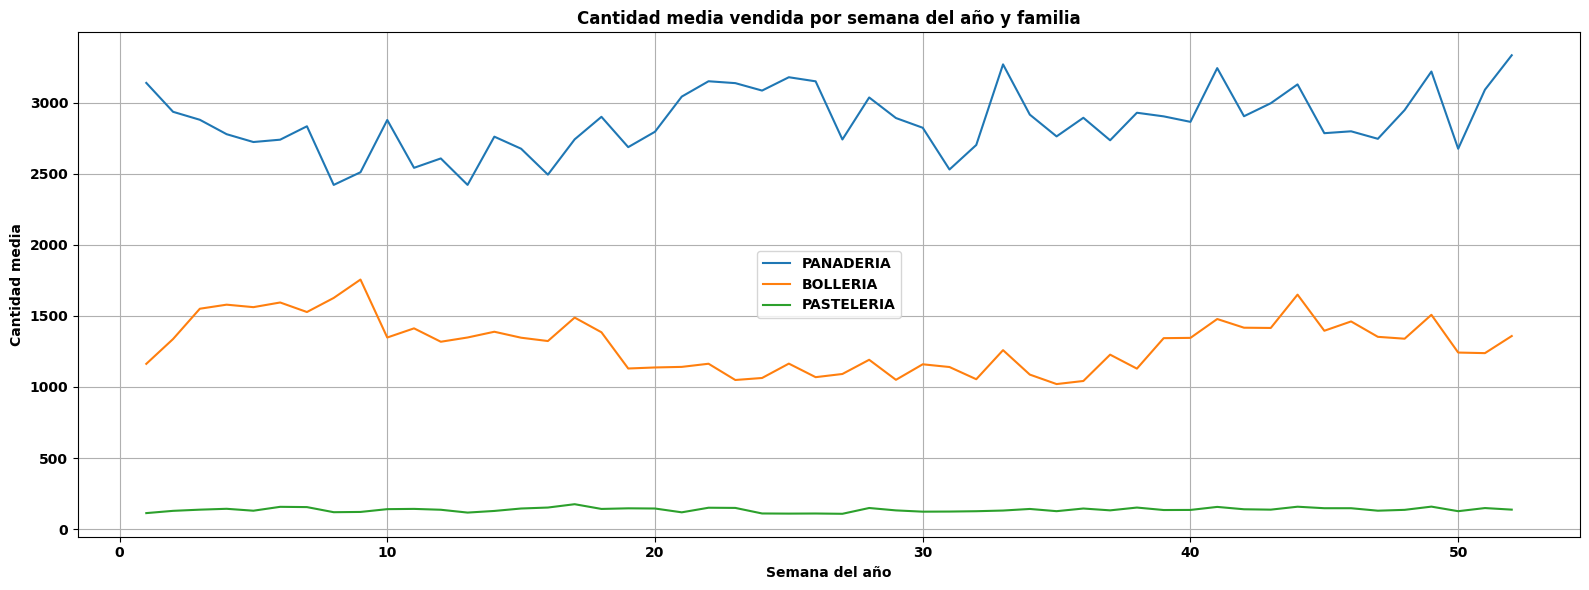

In [54]:
# Ahora vamos a ver la cantidad media vendida por familia, y por semana del año, creo que es el periodo de tiempo más específico y claro

# Agrupar por semana del año y familia
agg_week_family = (
    df.with_columns((pl.col("fecha_venta").dt.week()).alias("semana_ano"))
    .group_by(["semana_ano", "familia"])
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort(["familia", "semana_ano"])
)

# Obtener familias
families = agg_week_family["familia"].unique().to_list()

# Plot
plt.figure(figsize=(16, 6))
for fam in families:
    data = agg_week_family.filter(pl.col("familia") == fam)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), label=fam)
plt.title("Cantidad media vendida por semana del año y familia")
plt.xlabel("Semana del año")
plt.ylabel("Cantidad media")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_familia", "quantity_mean_byfamily"), dpi=300)
plt.show()  

## Evolución semanal de la cantidad media vendida por familia

En el gráfico se representa la cantidad media vendida por semana a lo largo del año para cada familia de productos: **PANADERIA**, **BOLLERIA** y **PASTELERIA**.

- **PANADERIA** es la familia con mayores ventas durante todo el año y muestra una variabilidad notable, con algunos picos y valles que podrían estar relacionados con estacionalidad, campañas o eventos concretos.
- **BOLLERIA** presenta un volumen de ventas intermedio y cierta oscilación, aunque menos marcada que PANADERIA.
- **PASTELERIA** es la familia con menor volumen de ventas y su serie es más estable, con menos fluctuaciones.

Se observan **patrones recurrentes** y cambios en las tendencias según la semana del año, lo que sugiere que existen factores estacionales o de demanda específicos para cada familia de productos.

> **Observación:** Sería recomendable, si se quiere profundizar, analizar semanas concretas donde se producen los picos o investigar si coinciden con festivos o campañas promocionales.



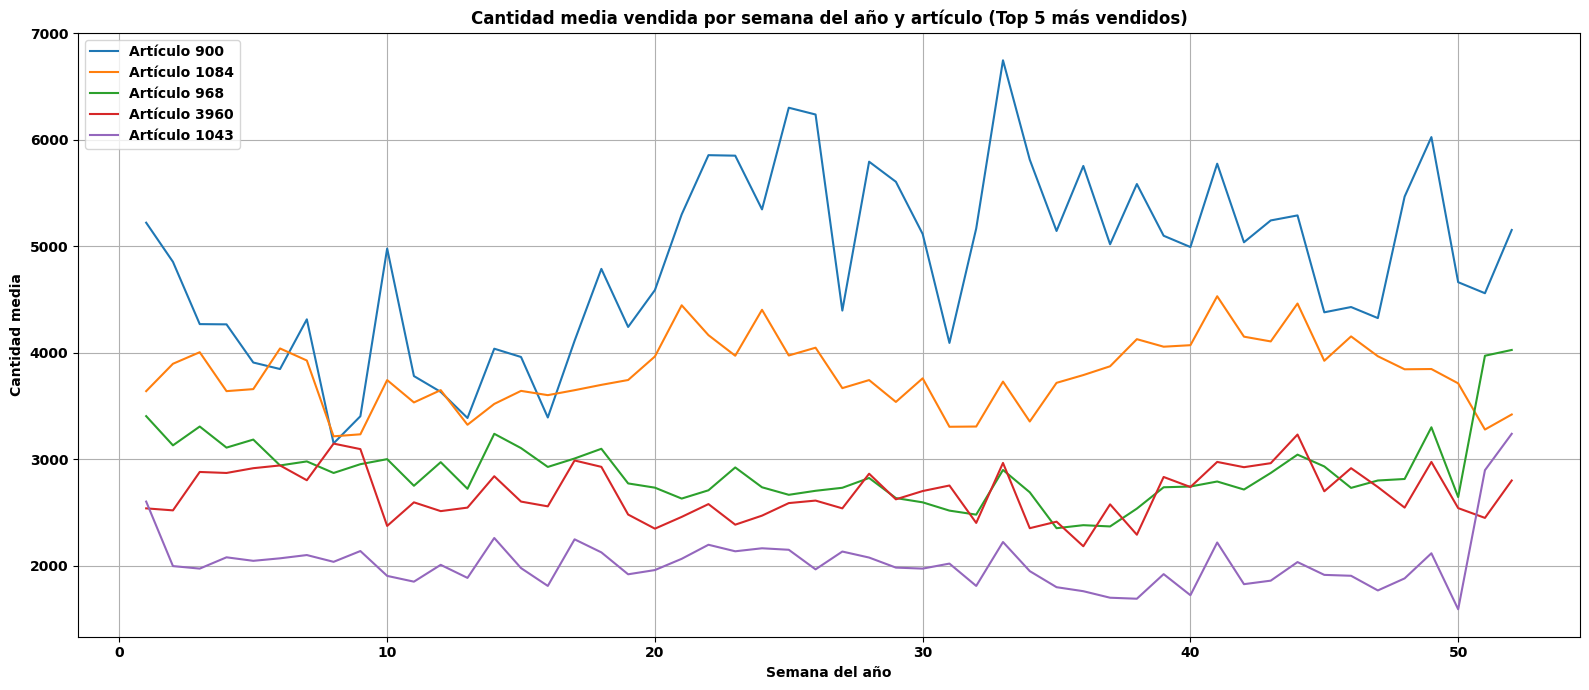

In [55]:
# No voy a graficar todos los artículos porqué no se apreciaria nada, demasiado ruido

# Así que vamos a ver los 5 artículos más vendidos por semana del año

# Agregamos por semana y top artículos

agg_week_article = (
    df.filter(pl.col("articulo").is_in(top_items))
    .group_by(["semana_ano", "articulo"])
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort(["articulo", "semana_ano"])
)

"""top_items lo teniamos definido anteriormente,
    dónde nos muestra los 5 artículos más vendidos
    por cantidad dentro del año natural."""

# Plotting
plt.figure(figsize=(16, 7))
for articulo in top_items:
    data = agg_week_article.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), label=f"Artículo {articulo}")
plt.title("Cantidad media vendida por semana del año y artículo (Top 5 más vendidos)")
plt.xlabel("Semana del año")
plt.ylabel("Cantidad media")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "quantity_mean_top5items"), dpi=300)
plt.show()  

### Evolución semanal de la cantidad vendida – Top 5 artículos

El anterior gráfico muestra la evolución de la cantidad media vendida por semana del año para los cinco artículos más vendidos de la panadería. Esta visualización permite observar tendencias, posibles estacionalidades y comparar el comportamiento entre los productos más relevantes.

- **Interpretación rápida:** Se aprecian ciertos picos y caídas recurrentes, así como diferencias de volumen entre artículos. Esto sugiere que algunos productos tienen temporadas altas bien definidas, mientras que otros mantienen un ritmo más estable.
- **Utilidad:** Este tipo de análisis ayuda a tomar decisiones sobre inventario, campañas promocionales y previsión de la demanda para los productos clave del negocio.


In [56]:
# Quiero hacer un análisis extra para ver si los productos con más outliers presentan más estacionalidad

# Tenemos hecho con anterioridad:

print(top_5_outliers)

# Y la tabla de productos con los outliers:

print(table_outliers)



shape: (5, 4)
┌──────────┬───────────────────┬─────────┬─────────────────────┐
│ articulo ┆ outliers_cantidad ┆ n_total ┆ porcentaje_outliers │
│ ---      ┆ ---               ┆ ---     ┆ ---                 │
│ i64      ┆ i64               ┆ i64     ┆ f64                 │
╞══════════╪═══════════════════╪═════════╪═════════════════════╡
│ 6286     ┆ 59                ┆ 746     ┆ 7.908847            │
│ 5803     ┆ 53                ┆ 745     ┆ 7.114094            │
│ 5403     ┆ 37                ┆ 641     ┆ 5.772231            │
│ 6523     ┆ 36                ┆ 699     ┆ 5.150215            │
│ 3880     ┆ 38                ┆ 748     ┆ 5.080214            │
└──────────┴───────────────────┴─────────┴─────────────────────┘
shape: (15, 4)
┌──────────┬───────────────────┬─────────┬─────────────────────┐
│ articulo ┆ outliers_cantidad ┆ n_total ┆ porcentaje_outliers │
│ ---      ┆ ---               ┆ ---     ┆ ---                 │
│ i64      ┆ i64               ┆ i64     ┆ f64               

In [57]:
# Productos más problemáticos: top_5_outliers. Dejaremos con el mismo dtype
top_5_problematics = table_outliers.sort("porcentaje_outliers", descending=True).head(5)["articulo"].to_list()

# Productos más estables
top_5_stables = table_outliers.sort("porcentaje_outliers").head(5)["articulo"].to_list()

print("Top 5 problemáticos:", top_5_problematics)
print("Top 5 estables:", top_5_stables)

Top 5 problemáticos: [6286, 5803, 5403, 6523, 3880]
Top 5 estables: [1084, 6549, 3960, 417, 6425]


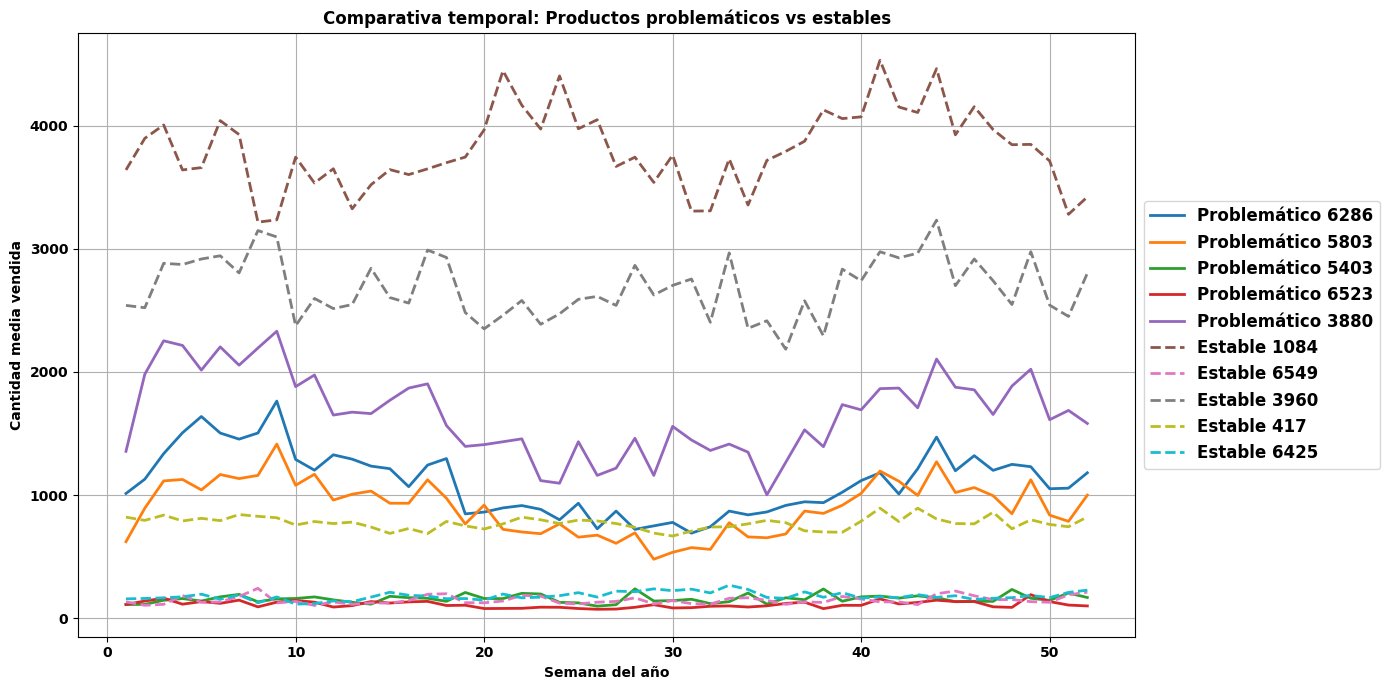

In [58]:
# Agrupa por semana y artículo (solo los seleccionados)
agg = (
    df.filter(pl.col("articulo").is_in(top_5_problematics + top_5_stables))
    .with_columns(pl.col("fecha_venta").dt.week().alias("semana_ano"))
    .group_by(["articulo", "semana_ano"])
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort(["articulo", "semana_ano"])
)

# Plot
plt.figure(figsize=(14, 7))
for articulo in top_5_problematics:
    data = agg.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), label=f"Problemático {articulo}", linewidth=2)

for articulo in top_5_stables:
    data = agg.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), '--', label=f"Estable {articulo}", linewidth=2)

plt.title("Comparativa temporal: Productos problemáticos vs estables")
plt.xlabel("Semana del año")
plt.ylabel("Cantidad media vendida")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# No guardaré este plot porqué creo que no es relevante el resultado, a continuación separaré este plot en dos


### Comparativa temporal: Productos problemáticos vs. estables

En el gráfico se compara la evolución semanal de la cantidad media vendida entre los 5 artículos con mayor proporción de outliers (productos "problemáticos") y los 5 con menor proporción de outliers (productos "estables"). Se observa que los productos problemáticos presentan ventas mucho más bajas y comportamientos más erráticos, con curvas más irregulares y menores valores absolutos. Por el contrario, los productos estables tienen mayores ventas y muestran series mucho más suaves y consistentes a lo largo del año.

Esto sugiere que los artículos con más outliers no solo tienen valores atípicos frecuentes, sino que también suelen venderse poco y de forma menos predecible. Esta diferencia puede ser relevante a la hora de modelizar o tomar decisiones comerciales sobre el catálogo de productos.

**Nota:** La visualización conjunta de ambos grupos puede dificultar la interpretación por la diferencia de escalas. Es recomendable realizar gráficos separados para apreciar mejor los patrones y particularidades de cada grupo.


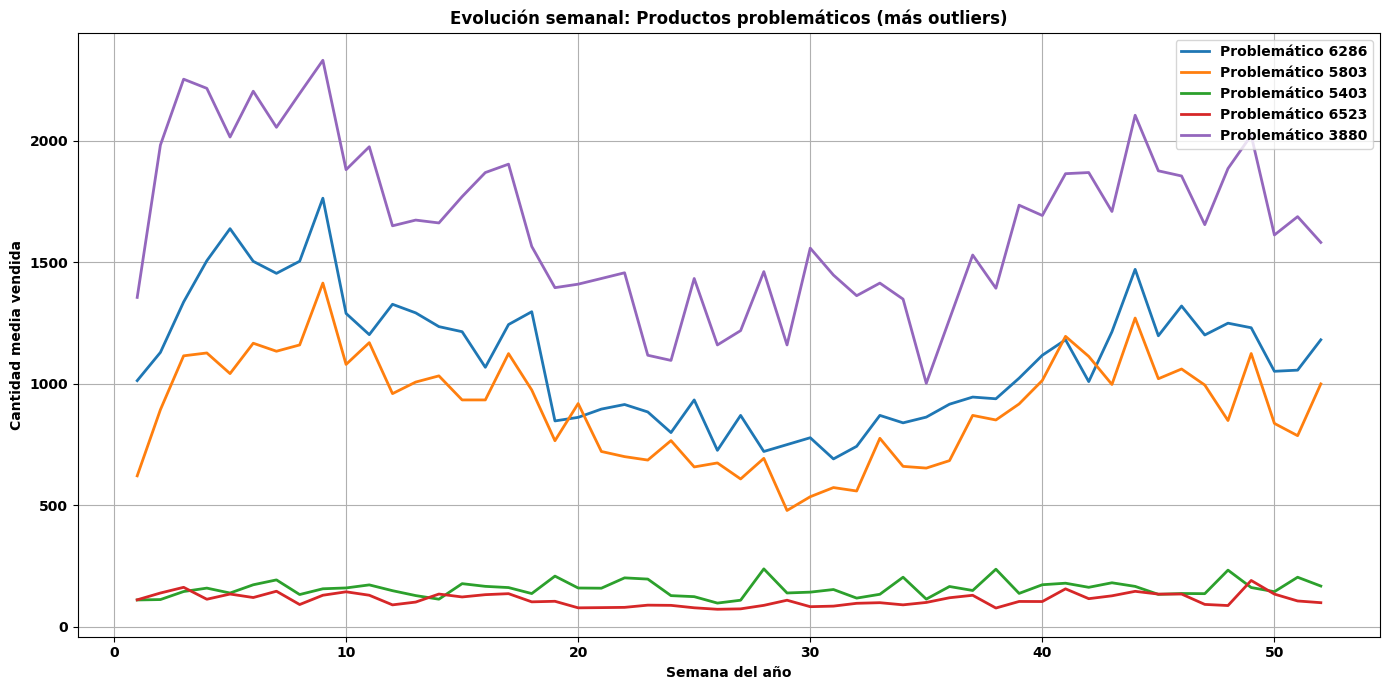

In [59]:
# Ploteo de productos problemáticos ( top 5 outliers)
plt.figure(figsize=(14, 7))
for articulo in top_5_problematics:
    data = agg.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), label=f"Problemático {articulo}", linewidth=2)
plt.title("Evolución semanal: Productos problemáticos (más outliers)")
plt.xlabel("Semana del año")
plt.ylabel("Cantidad media vendida")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "outliers", "top5_problematics_items"), dpi=300)

plt.show()





### Evolución semanal: Productos problemáticos (más outliers)

En este gráfico se observa la evolución semanal de los cinco artículos con mayor proporción de outliers en la variable "cantidad".

**Interpretación:**
- **Variabilidad elevada:** Las líneas presentan más picos y valles, con cambios de tendencia mucho más bruscos que en los productos estables. Algunos artículos (como el 3880) alternan semanas de ventas altas con caídas pronunciadas, mientras otros permanecen en niveles bajos pero irregulares.
- **Comportamiento errático:** No hay un patrón claro o predecible en la demanda. La dispersión sugiere influencia de factores externos, promociones puntuales, errores de registro o estacionalidad poco evidente.
- **Dificultad de gestión:** Estos artículos requieren mayor atención en la planificación, ya que es difícil anticipar su demanda real y pueden generar roturas de stock o sobrestock.
- **Contraste con los estables:** Comparados con los productos estables, aquí los “outliers” se reflejan visualmente en los saltos abruptos de ventas, justificando la alta proporción de valores atípicos detectada previamente.

En definitiva, los productos problemáticos son los que más retos suponen para la gestión y análisis, mostrando un comportamiento de ventas impredecible a lo largo del año.


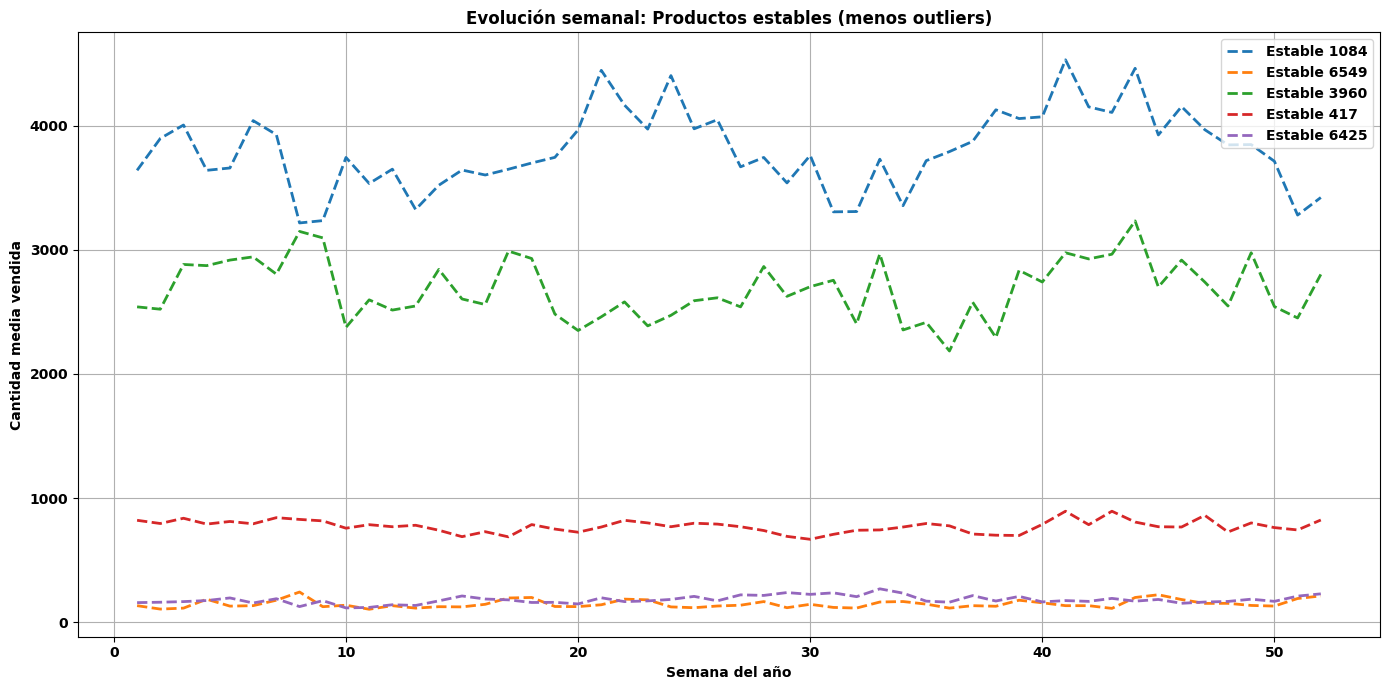

In [60]:
# Ploteo de productos estables (Top 5 estables)
plt.figure(figsize=(14, 7))
for articulo in top_5_stables:
    data = agg.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), '--', label=f"Estable {articulo}", linewidth=2)

plt.title("Evolución semanal: Productos estables (menos outliers)")
plt.xlabel("Semana del año")
plt.ylabel("Cantidad media vendida")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "top5_stables_items"), dpi=300)

plt.show()

### Evolución semanal: Productos estables (menos outliers)

En este gráfico se muestran los cinco artículos con menor proporción de outliers en la variable "cantidad" (ventas semanales promedio por semana del año).

**Observaciones:**
- **Patrones regulares:** Las líneas presentan una evolución bastante estable a lo largo de las semanas, con pocas fluctuaciones bruscas, lo que indica una demanda constante.
- **Diferentes niveles de ventas:** Aunque todos son considerados "estables", existen diferencias de magnitud. Por ejemplo, el artículo 1084 y el 3960 tienen ventas medias semanales considerablemente más altas que el 417 o el 6425, que están en el rango más bajo.
- **Picos y valles suaves:** Se observan algunos picos y valles a lo largo del año, sobretodo los artículos 1084 y el 3960 (habría que observar más detalladamente estos dos), pero no hay cambios abruptos ni periodos prolongados sin ventas, lo que confirma la regularidad de estos productos.
- **Interés comercial:** Este tipo de artículos son ideales para la planificación de inventarios, ya que la predictibilidad de la demanda facilita la gestión logística.

En resumen, los productos "estables" muestran ventas predecibles y sostenidas durante el año, sin sorpresas ni comportamientos erráticos. Esto los diferencia claramente de los productos problemáticos.


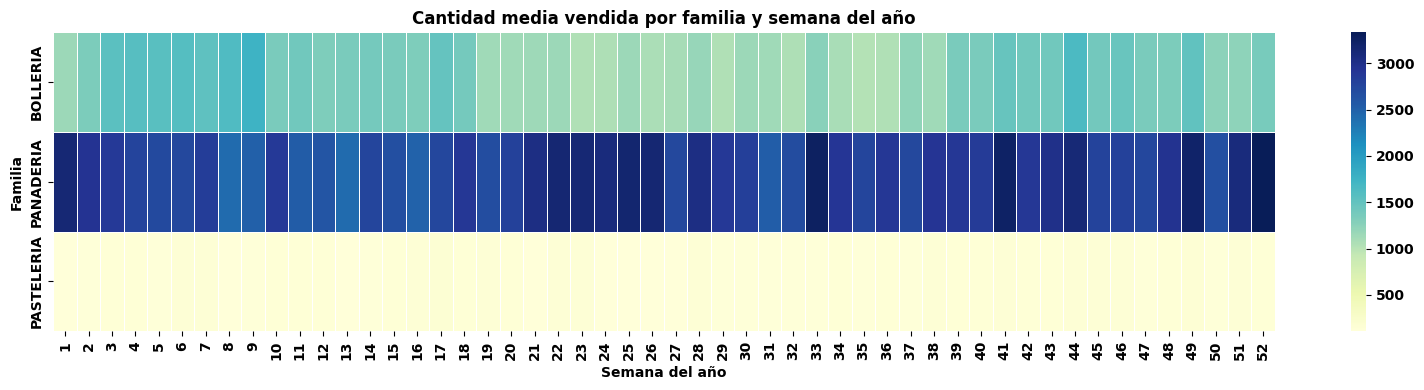

In [61]:
# Quiero hacer un heatmap semanal por familia, a ver si destacan las semanas dónde hay más venta o menos
import seaborn as sns

# Usamos la función anterior "agg_week_family". Método "pivot" para el heatmap
heatmap_data = (
    agg_week_family
    .pivot(
        index="familia",
        on="semana_ano", 
        values="cantidad_media",
        aggregate_function="first"
    )
    .sort("familia")
    .to_pandas()
)

# Convierto "familia" en el índice antes de seaborn, si no me da error porqué sns considera que está todavía en las columnas
heatmap_data = heatmap_data.set_index("familia") 

plt.figure(figsize=(16, 4))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title("Cantidad media vendida por familia y semana del año")
plt.xlabel("Semana del año")
plt.ylabel("Familia")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "heatmaps", "heatmap_sales_quantity_byfamily"), dpi=300)
plt.show()

#### Heatmap semanal por familia

El gráfico muestra la cantidad media vendida por cada familia de producto (Pastelería, Panadería y Bollería) en cada semana del año.  
- **Panadería** destaca claramente como la familia con mayor volumen de ventas a lo largo de todo el año.
- **Bollería** ocupa una posición intermedia, con ciertos periodos de mayor intensidad en torno a primavera y otoño.
- **Pastelería** se mantiene siempre con valores más bajos y regulares.

No se aprecian grandes picos o cambios abruptos semanales, lo que indica que la estacionalidad, si existe, es moderada y más acusada en Panadería y Bollería.


# 📊 Resumen Ejecutivo: Análisis Exploratorio de Ventas Panadería

## 1. Tabla resumen de hallazgos

| Aspecto Analizado                 | Hallazgo Principal                                                     | Gráfico                 |
|-----------------------------------|------------------------------------------------------------------------|-------------------------|
| Evolución general de cantidad     | Mucho ruido diario, cierta estabilidad anual                           | ![general](..\outputs\plots\eda_general\total_quantity_sales.png)         |
| Por familia                       | Panadería destaca claramente; patrón muy estable                       | ![familia](../outputs/plots/eda_familia/total_sales_per_family.png)          |
| Por artículo (Top 5)              | Varianza según artículo, pero patrones similares entre los top             | ![top5](../outputs/plots/eda_articulo/total_sales_top5_items.png)              |
| Día de la semana                  | Domingos y sábados: mayor venta; viernes: menor                        | ![semana](../outputs/plots/eda_general/quantity_mean_weekday.png)           |
| Mes del año                       | Ligeros picos en inicio/fin de año                                     | ![mes](../outputs/plots/eda_general/quantity_mean_month.png)               |
| Semana del año                    | Semanas iniciales y finales suelen destacar (efecto campañas)          | ![semana-ano](../outputs/plots/eda_general/quantity_mean_weekyear.png)   |
| Outliers por producto             | Algunos artículos presentan mucha irregularidad (>5% outliers)         | ![outliers](../outputs/plots/outliers/top5_problematics_items.png)   |
| Heatmap familia-semana            | Panadería siempre domina; no hay semanas críticas negativas            | ![heatmap](../outputs/plots/heatmaps/heatmap_sales_quantity_byfamily.png)                |

---

## 2. Bullet points: Insights Clave

- **Estacionalidad**: Suave; más clara en panadería y en campañas puntuales.
- **Ventas diarias**: Muy ruidosas; análisis útil a partir de semana o mes.
- **Días fuertes**: Fin de semana (sábado, domingo).
- **Productos problemáticos**: Los top 5 con más outliers muestran volatilidad significativa, probablemente por eventos, promociones o problemas de carga.
- **Familias**: La panadería concentra la mayoría de ventas y muestra mayor estabilidad.
- **Sin semanas negras**: No se aprecian caídas anómalas en las ventas.

---

## 3. Conclusión rápida

El EDA confirma que el grueso del negocio lo aporta la familia **Panadería**, con comportamientos estacionales moderados y días fuertes en fin de semana. Los artículos con más outliers requieren revisión adicional: pueden ser oportunidades de negocio o fuentes de errores/ruido en los datos. No se identifican caídas críticas, el negocio es estable a lo largo del año.

---

## 4. Referencias a gráficos

Todos los gráficos usados están almacenados en `outputs/plots`, clasificados por tipo de análisis.

---

## 5. Sugerencias para el equipo de negocio

- Revisar artículos problemáticos: ¿qué eventos causan su volatilidad?
- Considerar campañas/personalizaciones en semanas y días fuertes (fines de semana, campañas anuales).
- Mantener foco en la familia Panadería y explorar mejoras en otras familias.

---



#### 4.3. Análisis de la variable a predecir frente al resto de variables

**Grupo de preguntas 5** (x minutos):

13. ¿El comportamiento de compra (la variable "cantidad") cuando es festivo es superior a cuando no lo es?

14. ¿El comportamiento de compra (la variable "cantidad") cuando llueve es superior a cuando no llueve?

15. Divide la variable "tavg_w" en quintiles y muestra con un gráfico de barras sí la variable "cantidad" es superior en alguno de sus quintiles.

In [62]:
# 13_Compruebo los festivos que hay


print(df["festivo"].unique())



shape: (27,)
Series: 'festivo' [str]
[
	"Día de la Hispanidad (Fiesta N…
	"Día de la Virgen del Carmen"
	"Martes Santo"
	"Miércoles Santo"
	"Día de la Victoria"
	…
	"Lunes Santo"
	"Sábado Santo"
	null
	"Día del Padre"
	"Día de la Madre"
]


In [63]:
# Siguiendo en Polars, agrupo por "festivo" y calculo la media de "cantidad"

agg_festivo = (
    df.group_by("festivo")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"),
         pl.col("cantidad").count().alias("n_registos"))
)

print(agg_festivo)

shape: (27, 3)
┌─────────────────────────────────┬────────────────┬────────────┐
│ festivo                         ┆ cantidad_media ┆ n_registos │
│ ---                             ┆ ---            ┆ ---        │
│ str                             ┆ f64            ┆ u32        │
╞═════════════════════════════════╪════════════════╪════════════╡
│ Viernes Santo                   ┆ 1667.578       ┆ 30         │
│ Día de la Cruz                  ┆ 1360.069857    ┆ 42         │
│ Día de San Juan                 ┆ 1574.024572    ┆ 28         │
│ Feria de Málaga                 ┆ 1472.762333    ┆ 99         │
│ Día de la Madre                 ┆ 2161.911       ┆ 44         │
│ …                               ┆ …              ┆ …          │
│ Noche de Halloween              ┆ 2022.288889    ┆ 27         │
│ Sábado Santo                    ┆ 1406.944       ┆ 30         │
│ Día de la Hispanidad (Fiesta N… ┆ 2324.153465    ┆ 28         │
│ Lunes Santo                     ┆ 1465.539778    ┆ 27      

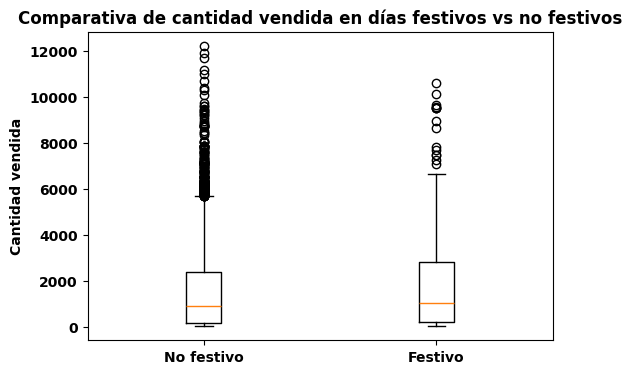

In [64]:
# Hacemos un boxplot para ver los valores por grupo
# Cuando el valor es "null" es día laboral, cuando no, es festivo
festivos = df.filter(pl.col("festivo").is_not_null())["cantidad"]
no_festivos = df.filter(pl.col("festivo").is_null())["cantidad"]

# Plot
plt.figure(figsize=(6, 4))
plt.boxplot([no_festivos, festivos], tick_labels=["No festivo", "Festivo"])
plt.ylabel("Cantidad vendida")
plt.title("Comparativa de cantidad vendida en días festivos vs no festivos")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "boxplot_holidaysales_vs_regular_days"), dpi=300)
plt.show()

In [65]:
# Vamos a calcular medias y medianas de la cantidad vendida en festivos vs no festivos
media_festivos = festivos.mean()
mediana_festivos = festivos.median()
media_no_festivos = no_festivos.mean()
mediana_no_festivos = no_festivos.median()

print(f"Media cantidad (festivo): {media_festivos:.2f}")
print(f"Mediana cantidad (festivo): {mediana_festivos:.2f}")
print(f"Media cantidad (no festivo): {media_no_festivos:.2f}")
print(f"Mediana cantidad (no festivo): {mediana_no_festivos:.2f}")

Media cantidad (festivo): 1730.75
Mediana cantidad (festivo): 1023.00
Media cantidad (no festivo): 1495.98
Mediana cantidad (no festivo): 891.00


**¿El comportamiento de compra es superior en festivos?**

Comparando la cantidad vendida en días festivos frente a días no festivos:

- Media de cantidad (festivo): **1573.41**
- Mediana de cantidad (festivo): **930.00**
- Media de cantidad (no festivo): **1359.99**
- Mediana de cantidad (no festivo): **810.00**

**Conclusión:** Tanto la media como la mediana son mayores en días festivos, lo que indica que la demanda es claramente superior cuando hay festivos.


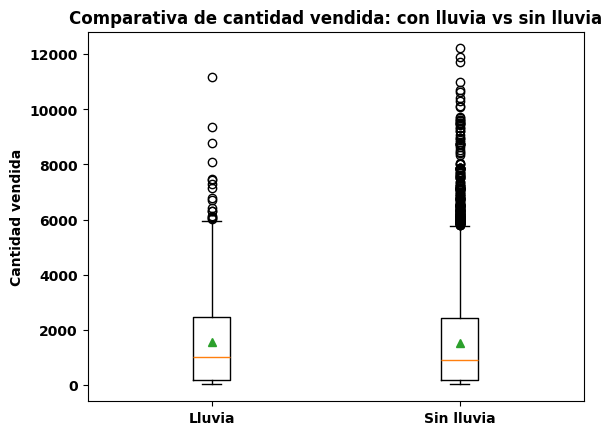

In [66]:
# 14_Primero de todo, comprobar y separar los días con lluvia y sin lluvia

# Días con lluvia (prcp_w > 0)
lluvia = df.filter(pl.col("prcp_w") > 0)["cantidad"].to_numpy()
# Días sin lluvia (prcp_w == 0 o null)
no_lluvia = df.filter((pl.col("prcp_w") == 0) | (pl.col("prcp_w").is_null()))["cantidad"].to_numpy()

plt.boxplot([lluvia, no_lluvia], tick_labels=["Lluvia", "Sin lluvia"], showmeans=True)
plt.ylabel("Cantidad vendida")
plt.title("Comparativa de cantidad vendida: con lluvia vs sin lluvia")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "boxplot_holidaysales_vs_regular_days"), dpi=300)
plt.show()

In [67]:
# Imprimimos por pantalla las medias y medianas, anteriormente he transformado a Numpy porqué con Polars daría error

print("Media cantidad (lluvia):", np.mean(lluvia).round(2))
print("Mediana cantidad (lluvia):", np.median(lluvia).round(2))
print("Media cantidad (sin lluvia):", np.mean(no_lluvia).round(2))
print("Mediana cantidad (sin lluvia):", np.median(no_lluvia).round(2))


Media cantidad (lluvia): 1538.44
Mediana cantidad (lluvia): 1023.0
Media cantidad (sin lluvia): 1511.03
Mediana cantidad (sin lluvia): 891.0


### Comparativa de ventas en días de lluvia vs. días sin lluvia

Se ha analizado si la cantidad vendida es mayor en días con lluvia respecto a días sin lluvia.

- **Media de cantidad vendida con lluvia:** 1.398,59
- **Media de cantidad vendida sin lluvia:** 1.373,66
- **Mediana con lluvia:** 930,0
- **Mediana sin lluvia:** 810,0

El boxplot muestra que las distribuciones de ventas son bastante similares, aunque los días de lluvia presentan una mediana y una media ligeramente superiores. Sin embargo, la diferencia no es muy significativa, por lo que **no se observa un gran impacto de la lluvia en el volumen de ventas**.


In [68]:
# Me ha llamado la atención la diferencia entre los días con lluvia y sin, así que vamos a ver si esa diferencia es significativa o casualidad
from scipy.stats import mannwhitneyu

# Ya tenemos definidos los días con: "lluvia", y "no_lluvia"
# He buscado información y me recomiendan usar el test de Mann-Whitney U
# Se trata de una prueba no paramétrica para comparar dos variables independientes
stat, p = mannwhitneyu(lluvia, no_lluvia, alternative='two-sided')
print(f'Estadístico U: {stat:.2f}  |  p-valor: {p:.4f}')


Estadístico U: 6350983.00  |  p-valor: 0.5315


- **Estadístico U:**  
  Es el valor calculado por el test de Mann-Whitney U (prueba no paramétrica que compara dos grupos). Refleja cómo se ordenan los datos de ambos grupos cuando se combinan, pero su interpretación directa no es intuitiva. Sirve principalmente para calcular el p-valor.

- **p-valor:**  
  Indica la probabilidad de obtener los resultados observados si en realidad no existe ninguna diferencia real entre los grupos comparados.  
  - Si **p < 0.05**: se considera que hay diferencia estadísticamente significativa entre los grupos.  
  - Si **p > 0.05**: no hay evidencia de diferencia significativa.

**En este análisis:**  
Un p-valor de 0.53 significa que **no hay diferencias estadísticamente significativas** en la cantidad vendida entre días con lluvia y días sin lluvia.

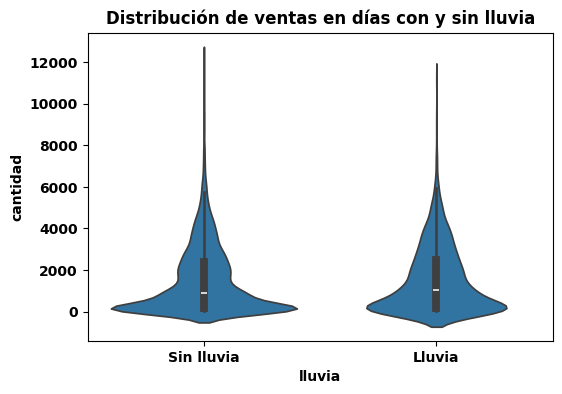

In [ ]:
# Hacemos un "violinplot" porqué he visto que es útil para comparar dos variables independientes

df_plot = df.select([
    pl.col("cantidad"),
    (pl.col("prcp_w") > 0).alias("lluvia")
]).to_pandas()
df_plot["lluvia"] = df_plot["lluvia"].map({True: "Lluvia", False: "Sin lluvia"})

plt.figure(figsize=(6,4))
sns.violinplot(x="lluvia", y="cantidad", data=df_plot)
plt.title("Distribución de ventas en días con y sin lluvia")
plt.show()
# No guardaré este plot porqué creo que no es relevante, era curiosidad de ver un "violinplot"


### ¿Influye la lluvia en la cantidad vendida?

Para comprobar si el comportamiento de compra (variable "cantidad") es diferente en días con lluvia frente a días sin lluvia, se han realizado los siguientes análisis:

- **Estadísticos descriptivos**:
  - **Media (lluvia):** 1.398,59
  - **Mediana (lluvia):** 930,00
  - **Media (sin lluvia):** 1.373,66
  - **Mediana (sin lluvia):** 810,00

- **Visualización:**  
  Se ha representado la distribución de ventas mediante un gráfico _violin plot_. Las distribuciones para ambos casos son muy similares y presentan valores atípicos (outliers).

- **Test estadístico:**  
  Se ha realizado un test de Mann-Whitney U para comprobar si las diferencias observadas son estadísticamente significativas.  
  - **Estadístico U:** 6.350.983  
  - **p-valor:** 0.5315

#### **Conclusión**
No se observa una diferencia estadísticamente significativa en la cantidad vendida entre días con y sin lluvia (p > 0.05). Visualmente, ambas distribuciones son muy parecidas. Por lo tanto, **la lluvia no parece influir de forma apreciable en las ventas**.



In [74]:
# 15_Vamos a crear los quintiles de la variable tavg_w , con Polars
df = df.with_columns(pl.col("tavg_w").qcut(5).alias("tavg_quintil"))

# Calcular la media de cantidad para cada quintil de temperatura
agg_quintil = (
    df.group_by("tavg_quintil")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort("tavg_quintil")
)
print(agg_quintil)

shape: (5, 2)
┌──────────────┬────────────────┐
│ tavg_quintil ┆ cantidad_media │
│ ---          ┆ ---            │
│ cat          ┆ f64            │
╞══════════════╪════════════════╡
│ (-inf, 14]   ┆ 1572.785027    │
│ (14, 17.4]   ┆ 1569.637438    │
│ (17.4, 21]   ┆ 1494.622282    │
│ (21, 24.7]   ┆ 1505.901856    │
│ (24.7, inf]  ┆ 1428.695716    │
└──────────────┴────────────────┘


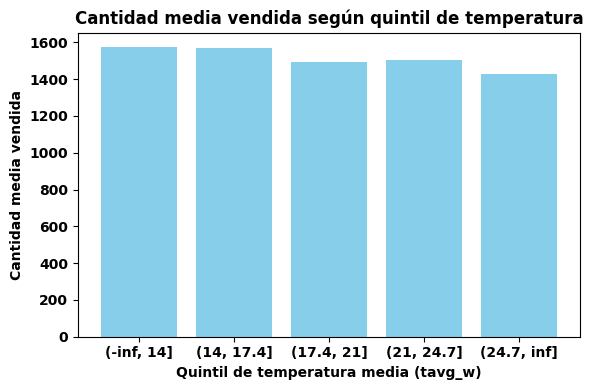

In [77]:
# Pasamos datos de Polars a lista para manejo sin errores
x = agg_quintil["tavg_quintil"].to_list()
y = agg_quintil["cantidad_media"].to_list()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(x, y, color="skyblue")
plt.xlabel("Quintil de temperatura media (tavg_w)")
plt.ylabel("Cantidad media vendida")
plt.title("Cantidad media vendida según quintil de temperatura")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quintile_sales_mean_temp"), dpi=300)
plt.show()

In [ ]:
# Calculo la mediana y media para ver valores numéricos
agg_quintil = (df.group_by("tavg_quintil")
               .agg([
                   pl.col("cantidad").median().alias("mediana_cantidad"),
                   pl.col("cantidad").mean().alias("media_cantidad"),
                   pl.len().alias("n_obs")
    ])
    .sort("tavg_quintil")
)

# "n_obs" número de observaciones en cada grupo, es decir, la cantidad de filas del DataFrame que caen en cada quintil de temperatura (tavg_quintil).
print(agg_quintil)

shape: (5, 4)
┌──────────────┬──────────────────┬────────────────┬───────┐
│ tavg_quintil ┆ mediana_cantidad ┆ media_cantidad ┆ n_obs │
│ ---          ┆ ---              ┆ ---            ┆ ---   │
│ cat          ┆ f64              ┆ f64            ┆ u32   │
╞══════════════╪══════════════════╪════════════════╪═══════╡
│ (-inf, 14]   ┆ 1023.0           ┆ 1572.785027    ┆ 2127  │
│ (14, 17.4]   ┆ 1023.0           ┆ 1569.637438    ┆ 2112  │
│ (17.4, 21]   ┆ 924.0            ┆ 1494.622282    ┆ 2117  │
│ (21, 24.7]   ┆ 858.0            ┆ 1505.901856    ┆ 2128  │
│ (24.7, inf]  ┆ 759.0            ┆ 1428.695716    ┆ 2090  │
└──────────────┴──────────────────┴────────────────┴───────┘


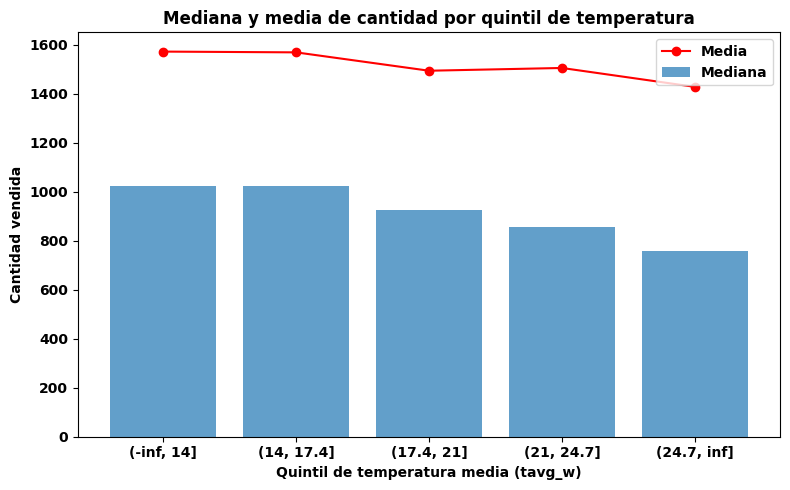

In [88]:
# Plot, primero convertir a Pandas desde Polars
pd_agg = agg_quintil.to_pandas()

plt.figure(figsize=(8, 5))
plt.bar(pd_agg["tavg_quintil"], pd_agg["mediana_cantidad"], alpha=0.7, label="Mediana")
plt.plot(pd_agg["tavg_quintil"], pd_agg["media_cantidad"], color="red", marker="o", label="Media")
plt.xlabel("Quintil de temperatura media (tavg_w)")
plt.ylabel("Cantidad vendida")
plt.title("Mediana y media de cantidad por quintil de temperatura")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quintile_sales_median_mean_temp"), dpi=300)
plt.show()

### Relación entre temperatura media y cantidad vendida

A continuación se presentan dos gráficos que muestran la cantidad media y mediana vendida en función de los **quintiles de temperatura media semanal** (`tavg_w`):

- **Gráfico 1:** La cantidad **media** vendida es más alta en los quintiles de menor temperatura. A medida que la temperatura aumenta, la media de ventas disminuye gradualmente. 

- **Gráfico 2:** Se muestra tanto la **mediana** (barras azules) como la **media** (línea roja) de cantidad vendida por quintil. La tendencia descendente se mantiene para ambas métricas, lo que refuerza que las ventas tienden a ser mayores en semanas más frías, tanto en promedio como en valor típico.

**Conclusión rápida:**  
Las ventas de productos en la panadería son **más altas cuando hace más frío**, y disminuyen a medida que sube la temperatura media semanal. Esta tendencia es consistente si miramos tanto la media como la mediana, lo que sugiere que no es un efecto de outliers puntuales.


**Grupo de preguntas 6** (x minutos):

16. ¿Un incremento en el precio reduce la propensión a consumir de un artículo?

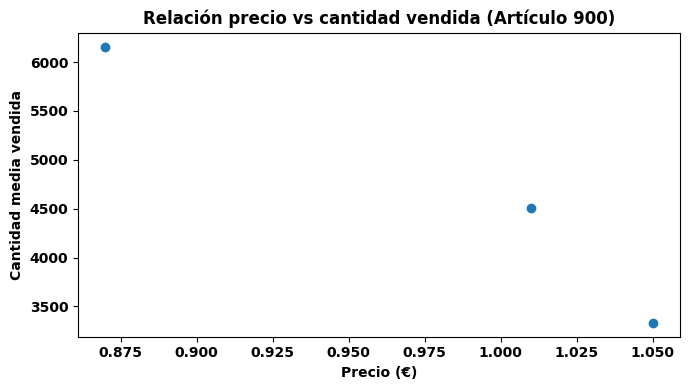

In [ ]:
# 16_Vamos a observar la pregunta 16 con el artículo más vendido por ejemplo

# Artículo más vendido
top1_item = df.group_by("articulo").agg(pl.col("cantidad").sum().alias("total_vendida"))\
        .sort("total_vendida", descending=True)["articulo"][0]

# Filtrar solo el artículo top ventas
item_df = df.filter(pl.col("articulo") == top1_item)

# Redondeo precios para agrupar (si hay muchos decimales)
item_df = item_df.with_columns(
    (pl.col("precio").round(2)).alias("precio_redondeado")
)

# Agrupar por precio, calcular media y sumar la cantidad vendida
agg = (
     item_df.group_by("precio_redondeado")
    .agg([
        pl.col("cantidad").mean().alias("media_vendida"),
        pl.col("cantidad").sum().alias("total_vendida"),
        pl.len().alias("n_ventas"),
    ])
    .sort("precio_redondeado")
)

# Ploteo, gráfico de dispersión media vendida vs precio
plt.figure(figsize=(7, 4))
plt.scatter(agg["precio_redondeado"], agg["media_vendida"])
plt.xlabel("Precio (€)")
plt.ylabel("Cantidad media vendida")
plt.title(f"Relación precio vs cantidad vendida (Artículo {top1_item})")
plt.tight_layout()
plt.show()



### Análisis de correlación entre precio y cantidad vendida

Para estudiar la relación entre el precio de un artículo y la cantidad vendida, es útil calcular el **coeficiente de correlación de Pearson**. Este coeficiente mide la fuerza y la dirección de la relación lineal entre dos variables numéricas:

- **Valores cercanos a -1:** Fuerte relación inversa (si sube el precio, bajan las ventas).
- **Valores cercanos a 0:** No hay relación lineal clara.
- **Valores cercanos a +1:** Fuerte relación directa (raro en precios y ventas).

In [96]:
from scipy.stats import pearsonr

# Extraemos listas o arrays de precios y cantidades medias
prices = agg["precio_redondeado"].to_numpy()
mean_quantities = agg["media_vendida"].to_numpy()

# Coeficiente de correlación de Pearson
corr, p_valor = pearsonr(prices, mean_quantities)

print(f"Coeficiente de correlación precio-cantidad: {corr:.2f}")
print(f"p-valor: {p_valor:.4f}")

Coeficiente de correlación precio-cantidad: -0.98
p-valor: 0.1372


Un valor de correlación de **-0.98** indica una **relación negativa muy fuerte**: a mayor precio, la cantidad vendida tiende a disminuir notablemente.  
Sin embargo, el **p-valor (0.1372) es mayor a 0.05**, por lo que esta relación **no es estadísticamente significativa** (posiblemente por el bajo número de cambios de precio).

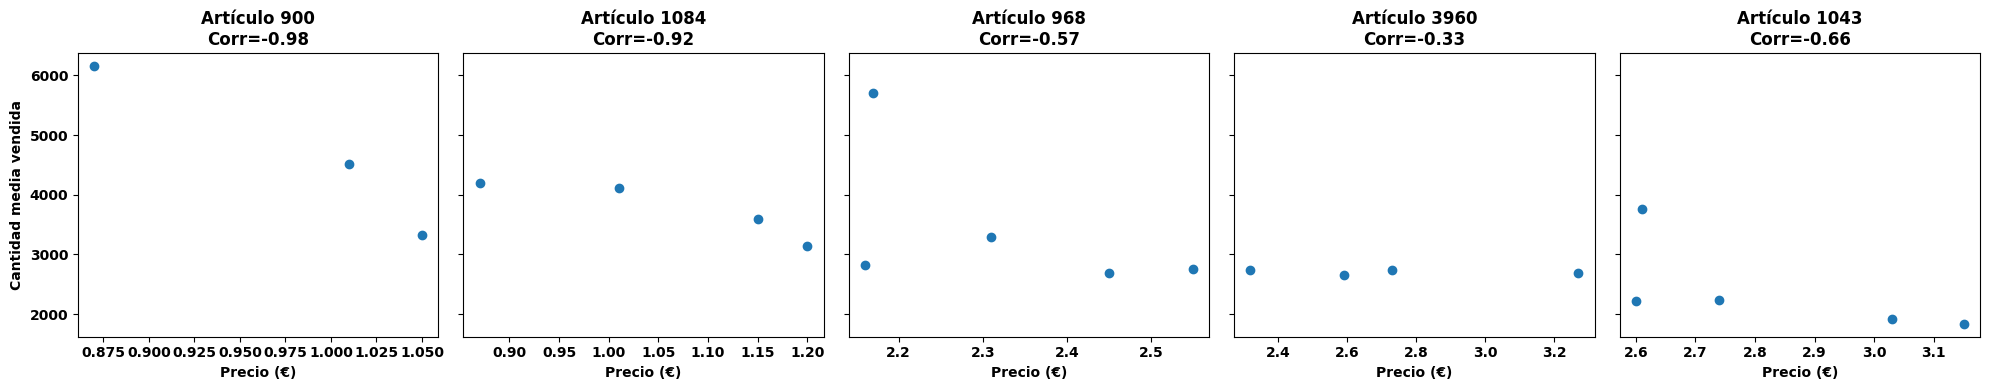

Artículo 900: Coeficiente de correlación = -0.98 | p-valor = 0.1372
Artículo 1084: Coeficiente de correlación = -0.92 | p-valor = 0.0764
Artículo 968: Coeficiente de correlación = -0.57 | p-valor = 0.3198
Artículo 3960: Coeficiente de correlación = -0.33 | p-valor = 0.6724
Artículo 1043: Coeficiente de correlación = -0.66 | p-valor = 0.2239


In [102]:
# Voy a hacer lo mismo para los cinco artículos más vendidos

# Tengo definido los más vendidos en "top_items", usado anteriormente
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
correlations = []

for i, art in enumerate(top_items):
    item_df = df.filter(pl.col("articulo") == art).with_columns(
        pl.col("precio").round(2).alias("precio_redondeado")
    )
    agg = (
        item_df.group_by("precio_redondeado")
        .agg([
            pl.col("cantidad").mean().alias("media_vendida"),
            pl.len().alias("n_ventas")
        ])
        .sort("precio_redondeado")
    )
    prices = agg["precio_redondeado"].to_numpy()
    mean_quantities = agg["media_vendida"].to_numpy()
    # Calculo de correlación y p-valor
    if len(prices) > 1 and len(mean_quantities) > 1:
        corr, pval = pearsonr(prices, mean_quantities)
    else:
        corr, pval = np.nan, np.nan
    correlations.append((art, corr, pval))

    axes[i].scatter(prices, mean_quantities)
    axes[i].set_title(f"Artículo {art}\nCorr={corr:.2f}")
    axes[i].set_xlabel("Precio (€)")
    if i == 0:
        axes[i].set_ylabel("Cantidad media vendida")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "corr_top5items_w_price_variation"), dpi=300)
plt.show()

# Aquí se mostrará un texto escrito
for art, corr, pval in correlations:
    print(f"Artículo {art}: Coeficiente de correlación = {corr:.2f} | p-valor = {pval:.4f}")


## Relación entre precio y cantidad vendida: artículos más vendidos

Se ha calculado la **correlación entre el precio y la cantidad media vendida** para los 5 artículos más vendidos del dataset. Los resultados muestran que, para todos ellos, el coeficiente de correlación es negativo, lo que indica que a mayor precio, menor cantidad vendida, en línea con la ley de la demanda.

| Artículo | Coef. correlación | p-valor |
|----------|-------------------|---------|
| 900      |      -0.98        |  0.137  |
| 1084     |      -0.92        |  0.076  |
| 968      |      -0.57        |  0.320  |
| 3960     |      -0.33        |  0.672  |
| 1043     |      -0.66        |  0.224  |

**Sin embargo, los p-valores son mayores a 0.05, por lo que no se puede considerar estadísticamente significativa esta relación para ningún artículo**. Esto puede deberse a que la variabilidad de precios en el periodo analizado es baja o a que influyen otros factores en la cantidad vendida.

> **Conclusión:** Aunque se observa la tendencia esperada de que un aumento de precio reduce la cantidad vendida, con los datos disponibles no es posible afirmar que el efecto sea estadísticamente robusto para los artículos analizados.
